In [1]:
# This notebook is testing stuff from the example experiment python file

In [2]:
# so we can use packages from parent directory
import sys
sys.path.append("..")

In [358]:
import torch
import torch.nn as nn
import numpy as np
from monroe_data import MonroeData, MonroeDataEntry, Color # last two for reading pkl file
import caption_featurizers
from color_featurizers import ColorFeaturizer, color_phi_fourier
from models import LiteralListener, LiteralSpeaker, CaptionEncoder, CaptionGenerator, PytorchModel, ColorEncoder
# from evaluation import score_model
# from experiment import FeatureHandler, evaluate_model
from scipy import stats # for pearsonr, spearmanr

In [6]:
train_data = MonroeData("../data/csv/train_corpus_monroe.csv", "../data/entries/train_entries_monroe.pkl")
dev_data = MonroeData("../data/csv/dev_corpus_monroe.csv", "../data/entries/dev_entries_monroe.pkl")

In [493]:
dev_data_synth = MonroeData("../data/csv/dev_corpus_synth2.csv", "../data/entries/dev_entries_synth2.pkl")

In [192]:
def score_model(test_data, scores, regressor=stats.pearsonr):
    """
    Assume scores are in the same order as the test data (i.e. 0th row is 0th score) and calculates a regression
    between the scores of the individual games and the scores from the model
    """
    relevant_columns = ["gameid", "roundNum", "numOutcome", "workerid_uniq"]
#     if speaker == Speaker.BY_WORKER_ID:
#         relevant_columns.append(Speaker.BY_WORKER_ID.value)

# #     if score == Score.COMPOSITE:
#         # no support for this yet but probably also need:
#         relevant_columns.extend(["contents", "clkTime", "msgTime"])

    eval_df = test_data.data[relevant_columns].copy()
    eval_df["model_scores"] = scores # why we need scores to be in same order as rows

    #true_scores = eval_df.groupby("gameid").numOutcome.mean()
    true_scores = eval_df.groupby("gameid").numOutcome.mean()


#     if score == score.SIMPLE:
#         # calculate scores as the mean of the number of successful utterances
#         # a speaker has
#         true_scores = eval_df.groupby(speaker.value).numOutcome.mean()
#     else:
#         true_scores = calculate_scores(eval_df, score)

    # calculate a model score
    #model_scores = eval_df.groupby("gameid").model_scores.mean()
    model_scores = eval_df.groupby("gameid").model_scores.mean()

    result = regressor(true_scores, model_scores)
    return result, true_scores, model_scores

In [193]:
def evaluate_model(assess_data, feature_handler, model, predictions_to_scores, model_scorer,
                    model_scorer_kwargs={}, accuracy=True):
    assess_features = feature_handler.test_features() # ~6 sec
    assess_targets = feature_handler.test_targets()
    model_outputs =  model.predict(assess_features)
    model_scores = predictions_to_scores(model_outputs, assess_targets) # decide what the score we're going to use is
    result, true_scores_grouped, model_scores_grouped = model_scorer(assess_data, model_scores, **model_scorer_kwargs)
    print(result)

    if accuracy: # also report accuracy
        model_predictions = np.argmax(model_outputs, axis=1)
        accuracy_val = sum(model_predictions == assess_targets) / len(assess_targets)
        print("Accuracy:", accuracy_val)
        
    return assess_targets, model_outputs, model_scores, true_scores_grouped, model_scores_grouped

In [486]:
# Literal Listener v2

# Initializing featurizers
print("Initializing featurizers")
caption_phi = caption_featurizers.CaptionFeaturizer(tokenizer=caption_featurizers.EndingTokenizer) # Use with parameter files that end in `endings_tkn` - using endings tokenizer to separate endings like "ish" and "er"
# caption_phi = caption_featurizers.CaptionFeaturizer(tokenizer=caption_featurizers.WhitespaceTokenizer) # Use with other paremter files

color_phi = ColorFeaturizer(color_phi_fourier, "rgb", normalized=True)

# Now we have a different target function, because we want to predict what the listener selected
def listener_click_target(data_entry, color_perm):
    # color_perm because colors are randomized
    return np.where(color_perm==data_entry.click_idx)[0]

feature_handler = FeatureHandler(train_data, dev_data, caption_phi, color_phi, target_fn=listener_click_target)

print("Obtaining training features") # get features even if you're runnning the pretrained model for example
train_features = feature_handler.train_features()
train_targets = feature_handler.train_targets()

print("Initializing model")
# model parameters
embed_dim = 100; hidden_dim = 100; color_dim= 54; # hard coded for example - 54 comes from color fourier phi





Initializing featurizers
Obtaining training features
Initializing model


In [494]:
# only used for evaluation...
feature_handler_synth = FeatureHandler(train_data, dev_data_synth, caption_phi, color_phi)

In [488]:
# Listener v2
# to train: (probably takes about 15 min - 2 hrs) depending on # of epochs (5 - 30)
train = True
model_file_v2 = "../model/literal_listener_listener_click_30epoch_endings_tkn.params"

model_v2 = LiteralListener(CaptionEncoder, num_epochs=30)
model_v2.init_model(embed_dim = embed_dim, hidden_dim = hidden_dim, vocab_size = feature_handler.caption_featurizer.caption_indexer.size,
             color_dim = color_dim)

if train:
    print("Training model and saving to {}:".format(model_file_v2))
    model_v2.fit(train_features, train_targets)
    model_v2.save_model(model_file_v2)
else:
    print("Loading pretrained model")
    model_v2.load_model(model_file_v2)

Training model and saving to ../model/literal_listener_listener_click_30epoch_endings_tkn.params:
---EPOCH 0---
0m 0s (0:0 0.00%) 0.0006
0m 11s (0:1000 6.38%) 1.1768
0m 23s (0:2000 12.77%) 1.0121
0m 35s (0:3000 19.15%) 0.9221
0m 49s (0:4000 25.53%) 0.8152
1m 1s (0:5000 31.92%) 0.9031
1m 14s (0:6000 38.30%) 0.6902
1m 27s (0:7000 44.69%) 0.6465
1m 39s (0:8000 51.07%) 0.6982
1m 51s (0:9000 57.45%) 0.5861
2m 3s (0:10000 63.84%) 0.5753
2m 15s (0:11000 70.22%) 0.5552
2m 27s (0:12000 76.60%) 0.5819
2m 39s (0:13000 82.99%) 0.6559
2m 52s (0:14000 89.37%) 0.6040
3m 4s (0:15000 95.75%) 0.5945
---EPOCH 1---
3m 13s (1:0 0.00%) 0.0002
3m 25s (1:1000 6.38%) 0.5890
3m 39s (1:2000 12.77%) 0.7242
3m 52s (1:3000 19.15%) 0.6509
4m 5s (1:4000 25.53%) 0.6767
4m 19s (1:5000 31.92%) 0.7144
4m 32s (1:6000 38.30%) 0.5211
4m 45s (1:7000 44.69%) 0.5502
4m 59s (1:8000 51.07%) 0.5648
5m 12s (1:9000 57.45%) 0.5127
5m 26s (1:10000 63.84%) 0.5005
5m 39s (1:11000 70.22%) 0.4923
5m 52s (1:12000 76.60%) 0.5377
6m 6s (1:1

61m 59s (15:14000 89.37%) 0.2092
62m 18s (15:15000 95.75%) 0.2570
---EPOCH 16---
62m 30s (16:0 0.00%) 0.0000
62m 46s (16:1000 6.38%) 0.4534
63m 2s (16:2000 12.77%) 0.4849
63m 18s (16:3000 19.15%) 0.2254
63m 35s (16:4000 25.53%) 0.3235
63m 52s (16:5000 31.92%) 0.2926
64m 11s (16:6000 38.30%) 0.2308
64m 28s (16:7000 44.69%) 0.3198
64m 45s (16:8000 51.07%) 0.3005
65m 2s (16:9000 57.45%) 0.2998
65m 22s (16:10000 63.84%) 0.2590
65m 39s (16:11000 70.22%) 0.4031
65m 56s (16:12000 76.60%) 0.4074
66m 14s (16:13000 82.99%) 0.4631
66m 32s (16:14000 89.37%) 0.2032
66m 51s (16:15000 95.75%) 0.2615
---EPOCH 17---
67m 4s (17:0 0.00%) 0.0000
67m 20s (17:1000 6.38%) 0.4561
67m 37s (17:2000 12.77%) 0.4351
67m 55s (17:3000 19.15%) 0.2593
68m 13s (17:4000 25.53%) 0.3266
68m 31s (17:5000 31.92%) 0.2668
68m 50s (17:6000 38.30%) 0.1975
69m 7s (17:7000 44.69%) 0.2824
69m 24s (17:8000 51.07%) 0.2500
69m 42s (17:9000 57.45%) 0.3101
70m 2s (17:10000 63.84%) 0.2463
70m 21s (17:11000 70.22%) 0.3988
70m 39s (17:120

In [82]:
# This is the one that doesn't make sense...
print("Evaluating model - Literal Listener Listener Click\t Target: listener click")
output_to_score = lambda model_outputs, targets: np.exp(model_outputs[np.arange(len(model_outputs)), targets]) # get the model's predicted probablity at each target index and use that as the score

# we want to score based on the model's predictions at the TARGET indices not listener clicked indices,
# so we change the feature_handler's target function to do that:
feature_handler.target_fn = listener_click_target
assess_targets_tgt_v2_lc, model_outputs_v2_lc, model_scores_v2_lc, true_scores_grouped_v2_lc, model_scores_grouped_v2_lc =\
    evaluate_model(dev_data, feature_handler, model_v2, output_to_score, score_model)

Evaluating model - Literal Listener Listener Click	 Target: listener click
(0.35798767951388855, 5.1153526322631263e-11)
Accuracy: 0.7853222718570517


In [83]:
# accuracy doesn't matter too much here bc it's trained to pick listener click and tested against speaker target
print("Evaluating model - Literal Listener Listener Click\t Target: speaker target")
output_to_score = lambda model_outputs, targets: np.exp(model_outputs[np.arange(len(model_outputs)), targets]) # get the model's predicted probablity at each target index and use that as the score

# we want to score based on the model's predictions at the TARGET indices not listener clicked indices,
# so we change the feature_handler's target function to do that:
feature_handler.target_fn = lambda data_entry, color_perm: np.where(color_perm == data_entry.target_idx)[0]
assess_targets_tgt_v2, model_outputs_v2, model_scores_v2, true_scores_grouped_v2, model_scores_grouped_v2 =\
    evaluate_model(dev_data, feature_handler, model_v2, output_to_score, score_model)

Evaluating model - Literal Listener Listener Click	 Target: speaker target
(0.302078052256305, 4.116391201368502e-08)
Accuracy: 0.7956604977664327


In [75]:
# literal listener v1
train = False
model_file_v1 = "../model/literal_listener_5epoch_endings_tkn.params"

model_v1 = LiteralListener(CaptionEncoder, num_epochs=5)
model_v1.init_model(embed_dim = embed_dim, hidden_dim = hidden_dim, vocab_size = feature_handler.caption_featurizer.caption_indexer.size,
             color_dim = color_dim)

if train:
    print("Training model and saving to {}:".format(model_file))
    #model_v1.fit(train_features, train_targets)
    #model_v1.save_model(model_file)
else:
    print("Loading pretrained model")
    model_v1.load_model(model_file_v1)
    
    
output_to_score = lambda model_outputs, targets: np.exp(model_outputs[np.arange(len(model_outputs)), targets]) # get the model's predicted probablity at each target index and use that as the score


Loading pretrained model


In [76]:
# This is the one that doesn't make sense...
print("Evaluating model - Literal Listener Speaker Target\t Target: listener click")
feature_handler.target_fn = listener_click_target
assess_targets_tgt_v1_lc, model_outputs_v1_lc, model_scores_v1_lc, true_scores_grouped_v1_lc, model_scores_grouped_v1_lc =\
    evaluate_model(dev_data, feature_handler, model_v1, output_to_score, score_model)


Evaluating model - Literal Listener Speaker Target	 Target: listener click
(0.3667183385453332, 1.5872865557272033e-11)
Accuracy: 0.794256541161455


In [77]:
print("Evaluating model - Literal Listener Speaker Target\t Target: speaker target")
feature_handler.target_fn = lambda data_entry, color_perm: np.where(color_perm == data_entry.target_idx)[0]
assess_targets_tgt_v1, model_outputs_v1, model_scores_v1, true_scores_grouped_v1, model_scores_grouped_v1 =\
    evaluate_model(dev_data, feature_handler, model_v1, output_to_score, score_model)

Evaluating model - Literal Listener Speaker Target	 Target: speaker target
(0.31542364118662225, 9.412595063827775e-09)
Accuracy: 0.8019783024888322


In [29]:
import matplotlib.pyplot as plt

In [30]:
%matplotlib inline

In [38]:
sum([1 if s > 0.5 else 0 for s in model_scores_v1])/len(model_scores_v1)

0.798468410976388

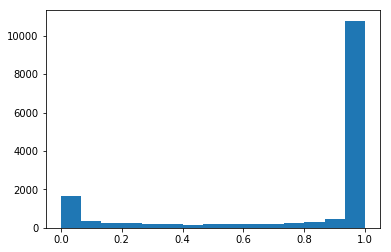

In [39]:
plt.hist(model_scores_v1, 15)
plt.show()

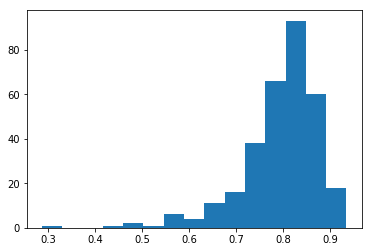

In [52]:
plt.hist(model_scores_grouped_v1, 15)
plt.show()

In [37]:
sum([1 if s > 0.5 else 0 for s in model_scores_v1_lc])/len(model_scores_v1_lc)

0.7903637523931079

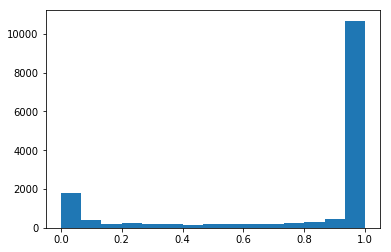

In [34]:
plt.hist(model_scores_v1_lc, 15)
plt.show()

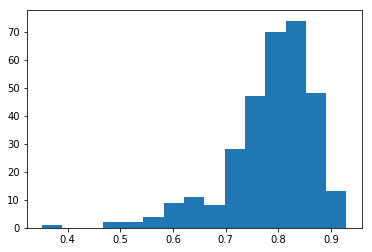

In [53]:
plt.hist(model_scores_grouped_v1_lc, 15)
plt.show()

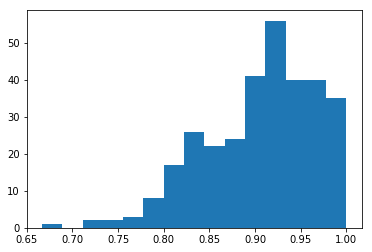

In [56]:
plt.hist(true_scores_grouped_v1_lc, 15)
plt.show()

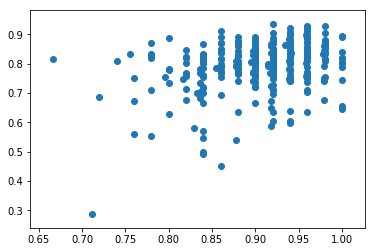

In [54]:
plt.scatter(true_scores_grouped_v1, model_scores_grouped_v1)
plt.show()

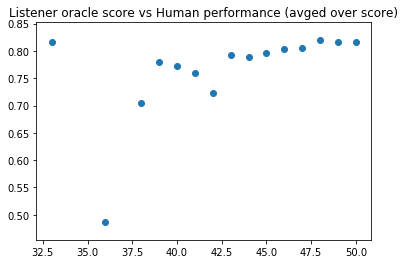

(0.518627932241207, 0.04761464052998845)

In [431]:
true_scores_grouped_rounded_v1 = [int(50*round_partial(score, 1/50)) for score in true_scores_grouped_v1]
listener_v1_df = pd.DataFrame({'model_scores': model_scores_grouped_v1, 'true_scores': true_scores_grouped_rounded_v1})
listener_v1_scores_series = listener_v1_df.groupby('true_scores').mean()['model_scores']
plt.scatter(listener_v1_scores_series.index, listener_v1_scores_series.values)
plt.title("Listener oracle score vs Human performance (avged over score)")
plt.show()
stats.pearsonr(listener_v1_scores_series.index, listener_v1_scores_series.values)

In [433]:
stats.spearmanr(listener_v1_scores_series.index, listener_v1_scores_series.values)

SpearmanrResult(correlation=0.7142857142857142, pvalue=0.0027743838176388096)

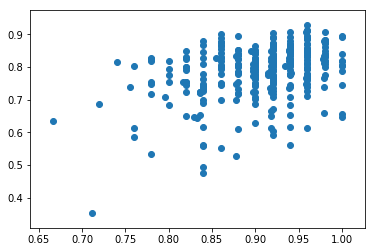

In [55]:
plt.scatter(true_scores_grouped_v1_lc, model_scores_grouped_v1_lc)
plt.show()

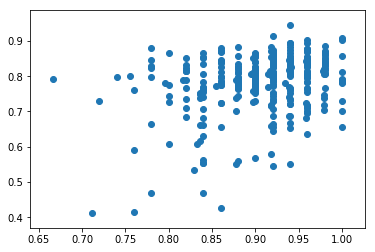

In [84]:
plt.scatter(true_scores_grouped_v2, model_scores_grouped_v2)
plt.title("Listener oracle score vs Human performance")
plt.show()

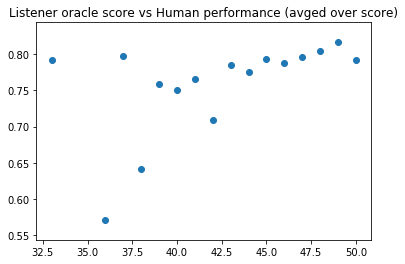

(0.5128058883174978, 0.04223188368351648)

In [430]:
true_scores_grouped_rounded_v2 = [int(50*round_partial(score, 1/50)) for score in true_scores_grouped_v2]
listener_v2_df = pd.DataFrame({'model_scores': model_scores_grouped_v2, 'true_scores': true_scores_grouped_rounded_v2})
listener_v2_scores_series = listener_v2_df.groupby('true_scores').mean()['model_scores']
plt.scatter(listener_v2_scores_series.index, listener_v2_scores_series.values)
plt.title("Listener oracle score vs Human performance (avged over score)")
plt.show()
stats.pearsonr(listener_v2_scores_series.index, listener_v2_scores_series.values)

In [434]:
stats.spearmanr(listener_v2_scores_series.index, listener_v2_scores_series.values)

SpearmanrResult(correlation=0.5823529411764706, pvalue=0.017932734131035355)

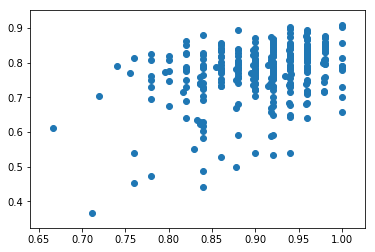

In [85]:
plt.scatter(true_scores_grouped_v2_lc, model_scores_grouped_v2_lc)
plt.show()

In [91]:
print("Evaluating model - Literal Listener Speaker Target\t Target: speaker target")
feature_handler.target_fn = lambda data_entry, color_perm: np.where(color_perm == data_entry.target_idx)[0]
assess_targets_tgt_v1, model_outputs_v1, model_scores_v1, true_scores_grouped_v1, model_scores_grouped_v1 =\
    evaluate_model(dev_data, feature_handler, model_v1, output_to_score, score_model)

Evaluating model - Literal Listener Speaker Target	 Target: speaker target
(0.3454967790563951, 8.056670916446157e-08)
Accuracy: 0.8019783024888322


In [69]:
stats.pearsonr(true_scores_grouped_v1, model_scores_grouped_v1)

(0.31542364625692165, 9.412589655236449e-09)

In [70]:
stats.pearsonr(true_scores_grouped_v1_lc, model_scores_grouped_v1_lc)

(0.366718349321275, 1.5872842282297345e-11)

In [26]:
sum(dev_data.data['numOutcome'])/dev_data.data.shape[0]

0.9039566049776643

In [27]:
sum(train_data.data['numOutcome'])/train_data.data.shape[0]

0.8862432173635493

In [ ]:
### Now, just predict listener success directly

In [146]:
class PredictSuccess(nn.Module):
    def __init__(self, embed_dim, hidden_dim, vocab_size):
        super(PredictSuccess, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(2*hidden_dim, 1)
        
    def forward(self, caption):
        embeddings = self.embed(caption)
        output, (hn, cn) = self.lstm(embeddings)
        binary_prediction = self.linear(output[:,-1,:])
        return binary_prediction
        

In [608]:
class PredictSuccessColor(nn.Module):
    def __init__(self, embed_dim, hidden_dim, vocab_size, color_in_dim, color_hidden_dim):
        super(PredictSuccessColor, self).__init__()
        self.color_encoder = ColorEncoder(color_in_dim, color_hidden_dim)
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(2*hidden_dim + color_hidden_dim, 1)
        #self.linear2 = nn.Linear(100, 1)
        
    def forward(self, caption, colors):
        color_embed = self.color_encoder(colors)
        embeddings = self.embed(caption)
        output, (hn, cn) = self.lstm(embeddings)
#         print("output shape:",output[:,-1,:].shape)
#         print("output unsqueezed shape:",output[:,-1,:].unsqueeze(0).shape)
#         print("color embed shape:",color_embed.shape)
        result = torch.cat((output[:,-1,:].unsqueeze(0), color_embed), dim=2)
        
        binary_prediction = self.linear(result).squeeze(0)
        return binary_prediction
        

In [536]:
class PredictSuccessColor2(nn.Module):
    def __init__(self, embed_dim, hidden_dim, vocab_size, color_in_dim, color_hidden_dim):
        super(PredictSuccessColor2, self).__init__()
        self.color_encoder = ColorEncoder(color_in_dim, color_hidden_dim)
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(2*hidden_dim + 2*color_hidden_dim, 1)
        #self.linear2 = nn.Linear(100, 1)
        
    def forward(self, caption, colors):
        color_embed = self.color_encoder(colors)
        embeddings = self.embed(caption)
        output, (hn, cn) = self.lstm(embeddings)
#         print("output shape:",output[:,-1,:].shape)
#         print("output unsqueezed shape:",output[:,-1,:].unsqueeze(0).shape)
#         print("color embed shape:",color_embed.shape)
        result = torch.cat((output[:,-1,:].unsqueeze(0), color_embed, color_embed), dim=2)
        # print("color result:", result.shape)
        binary_prediction = self.linear(result).squeeze(0)
        return binary_prediction

In [650]:
class PredictSuccessColor3(nn.Module):
    def __init__(self, embed_dim, hidden_dim, vocab_size, color_in_dim, color_hidden_dim):
        super(PredictSuccessColor3, self).__init__()
        self.color_encoder = ColorEncoder(color_in_dim, color_hidden_dim)
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim + color_in_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(2*hidden_dim + color_hidden_dim, 1)
        #self.linear2 = nn.Linear(100, 1)
        
    def forward(self, caption, colors):
        color_embed = self.color_encoder(colors)
        embeddings = self.embed(caption)
        
        # repeat target for number of tokens
        repeat_target = colors[:,-1,:].repeat(1, caption.shape[1], 1)
        #print(repeat_target)
        inputs = torch.cat((embeddings, repeat_target), dim=2) # cat along the innermost dimension
        
        
        output, (hn, cn) = self.lstm(inputs)
#         print("output shape:",output[:,-1,:].shape)
#         print("output unsqueezed shape:",output[:,-1,:].unsqueeze(0).shape)
#         print("color embed shape:",color_embed.shape)
        result = torch.cat((output[:,-1,:].unsqueeze(0), color_embed), dim=2)
        # print("color result:", result.shape)
        binary_prediction = self.linear(result).squeeze(0)
        return binary_prediction

In [620]:
class LiteralListenerPredictSuccess(PytorchModel):
    def __init__(self, model, use_color=True, **kwargs):
        super(LiteralListenerPredictSuccess, self).__init__(model, **kwargs)
        self.use_color = use_color
    def train_iter(self, caption_tensor, color_tensor, target, optimizer, criterion):
        """
        Iterates through a single training pair, querying the model, getting a loss and
        updating the parameters. (TODO: addd some kind of batching to this).

        Very much inspired by the torch NMT example/tutorial thingy
        """
        # start_states = self.model.init_hidden_and_context()
        #input_length = caption_tensor.size(0)
        optimizer.zero_grad()
        loss = 0
        
        if self.use_color:
            # flip order of tensor
            color_tensor = np.flip(color_tensor.numpy(), axis=1).copy()
            color_tensor = torch.from_numpy(color_tensor)
            
            model_output = self.model(caption_tensor, color_tensor)
        else:
            model_output = self.model(caption_tensor)
        target = target.view(-1, 1).float() # Binary cross entropy (BCE) loss requires targets to be floats and not longs
        
        # target should just be a single number
        loss += criterion(model_output, target)
        loss.backward()
        optimizer.step()
        
        return loss

    def predict(self, X):
        model_outputs = np.empty([len(X)])
        self.model.eval()
        with torch.no_grad():
            for i, feature in enumerate(X):
                caption, colors = feature
                caption = torch.tensor([caption], dtype=torch.long)
                colors = torch.tensor([colors], dtype=torch.float)
                if self.use_color:
                    # flip order of tensor
                    colors = np.flip(colors.numpy(), axis=1).copy()
                    colors = torch.from_numpy(colors)
                    model_output_np = self.model(caption, colors).view(-1).numpy()
                else:
                    model_output_np = self.model(caption).view(-1).numpy()
                model_outputs[i] = model_output_np

        return np.array(model_outputs)

In [597]:
print("Initializing featurizers")
caption_phi = caption_featurizers.CaptionFeaturizer(tokenizer=caption_featurizers.EndingTokenizer) # Use with parameter files that end in `endings_tkn` - using endings tokenizer to separate endings like "ish" and "er"
# caption_phi = caption_featurizers.CaptionFeaturizer(tokenizer=caption_featurizers.WhitespaceTokenizer) # Use with other paremter files

# def flip_color_phi_fourier(color_list, space):
#     """ color_list is a list of three color coordinates """
#     color_features = color_phi_fourier(color_list, space)
#     # reverse color order so target is last - this makes it so the last hidden state of
#     # the color encoder LSTM has more recent info about the target color (shouldn't matter but that's what Monroe does)
#     # We make a copy so it's compatible with pytorch tensors - pytorch doesn't like backwards np.arrays for some reason
#     # print(len(color_features))
#     color_features = np.flip(color_features, axis=0).copy()

#     return color_features

color_phi = ColorFeaturizer(color_phi_fourier, "hsv", normalized=True) 

# Now we have a different target function, because we want to predict what the listener selected
def success_target(data_entry):
    # color_perm because colors are randomized, but this doesn't really matter
    return 1 if data_entry.target_idx == data_entry.click_idx else 0



feature_handler_suc = FeatureHandler(train_data, dev_data_synth, caption_phi, color_phi,
                                     target_fn=success_target, randomized_colors=False)

print("Obtaining training features") # get features even if you're runnning the pretrained model for example
train_features = feature_handler_suc.train_features()
train_targets = feature_handler_suc.train_targets()

print("Initializing model")
# model parameters
embed_dim = 100; hidden_dim = 100; # hard coded for example - 54 comes from color fourier phi


Initializing featurizers
Obtaining training features
Initializing model


In [577]:
color_phi_fourier([train_data[0].colors[0].hsv_norm, train_data[0].colors[1].hsv_norm, train_data[0].colors[2].hsv_norm], "hsv_norm").shape

#np.flip([[1, 2, 3], [4, 5, 6]], axis=0)

(162,)

In [598]:
train_features[0][1]

array([[ 1.        , -0.955793  ,  0.82708055, -0.94611347,  0.809068  ,
        -0.6004896 ,  0.7902614 , -0.5751473 ,  0.30918208, -0.6946584 ,
         0.8754645 , -0.9788674 ,  0.89017326, -0.98479265,  0.99234265,
        -0.98975146,  0.9879867 , -0.8988701 , -0.0348995 , -0.2605045 ,
         0.53287625, -0.29061916,  0.55912095, -0.77818865,  0.5848169 ,
        -0.7974792 ,  0.93963325,  0.        , -0.29404032,  0.56208336,
        -0.3238353 ,  0.587715  , -0.79963255,  0.6127699 , -0.8180499 ,
         0.9510029 ,  0.7193398 , -0.4832824 ,  0.20449606, -0.45562217,
         0.17373364,  0.12351536,  0.14280072,  0.1545389 , -0.43821514,
        -0.99939084,  0.96547264, -0.8461932 ,  0.9568388 , -0.8290861 ,
         0.6280306 , -0.81116533,  0.6033464 , -0.34218323],
       [ 1.        , -0.97922283,  0.91775465, -0.97624546,  0.91202444,
        -0.8099048 ,  0.90611047, -0.8014967 ,  0.66357714,  0.22495106,
        -0.02268733, -0.18051915, -0.00849321, -0.19446324,  0.

In [582]:
train_features[0][1]

array([[-0.3815018 ,  0.18612514,  0.01698581,  0.17215896,  0.03117754,
        -0.23321848,  0.04536299, -0.24699901,  0.43837115,  0.81485736,
        -0.9154749 ,  0.9780505 , -0.9210946 ,  0.9809098 , -0.99996394,
         0.98357147, -0.9997426 ,  0.97437006,  0.74810785, -0.5979992 ,
         0.42304116, -0.5865613 ,  0.41013584, -0.21666741,  0.3971479 ,
        -0.2027873 ,  0.        , -0.9243681 ,  0.98252606, -0.99985576,
         0.98506916, -0.99951386,  0.9724244 , -0.99897057,  0.9690157 ,
        -0.89879405, -0.5796615 ,  0.40237504, -0.20836814,  0.38933888,
        -0.19446324, -0.00849321, -0.18051915, -0.02268733,  0.22495106,
         0.66357714, -0.8014967 ,  0.90611047, -0.8099048 ,  0.91202444,
        -0.97624546,  0.91775465, -0.97922283,  1.        ],
       [-0.9583226 ,  0.91495967, -0.8571673 ,  0.91283417, -0.8544588 ,
         0.78260815, -0.85172695,  0.77933794, -0.6946584 ,  0.6238796 ,
        -0.7169106 ,  0.7986355 , -0.72055113,  0.80177563, -0.

In [583]:
np.flip(train_features[0][1], axis=1)

array([[ 1.        , -0.97922283,  0.91775465, -0.97624546,  0.91202444,
        -0.8099048 ,  0.90611047, -0.8014967 ,  0.66357714,  0.22495106,
        -0.02268733, -0.18051915, -0.00849321, -0.19446324,  0.38933888,
        -0.20836814,  0.40237504, -0.5796615 , -0.89879405,  0.9690157 ,
        -0.99897057,  0.9724244 , -0.99951386,  0.98506916, -0.99985576,
         0.98252606, -0.9243681 ,  0.        , -0.2027873 ,  0.3971479 ,
        -0.21666741,  0.41013584, -0.5865613 ,  0.42304116, -0.5979992 ,
         0.74810785,  0.97437006, -0.9997426 ,  0.98357147, -0.99996394,
         0.9809098 , -0.9210946 ,  0.9780505 , -0.9154749 ,  0.81485736,
         0.43837115, -0.24699901,  0.04536299, -0.23321848,  0.03117754,
         0.17215896,  0.01698581,  0.18612514, -0.3815018 ],
       [ 1.        , -0.9921147 ,  0.96858317, -0.9914449 ,  0.96726775,
        -0.92783624,  0.9659258 , -0.9258706 ,  0.8712138 , -0.37460658,
         0.48785967, -0.5934189 ,  0.49242356, -0.59762514,  0.

In [570]:
train_data[0].colors[0].hsv_norm

[0.6277777777777778, 0.8950276243093923, 0.905]

In [595]:
color_phi_fourier(train_data[0].colors[0].hsv_norm, space="hsv_norm")

array([ 1.        , -0.955793  ,  0.82708055, -0.94611347,  0.809068  ,
       -0.6004896 ,  0.7902614 , -0.5751473 ,  0.30918208, -0.6946584 ,
        0.8754645 , -0.9788674 ,  0.89017326, -0.98479265,  0.99234265,
       -0.98975146,  0.9879867 , -0.8988701 , -0.0348995 , -0.2605045 ,
        0.53287625, -0.29061916,  0.55912095, -0.77818865,  0.5848169 ,
       -0.7974792 ,  0.93963325,  0.        , -0.29404032,  0.56208336,
       -0.3238353 ,  0.587715  , -0.79963255,  0.6127699 , -0.8180499 ,
        0.9510029 ,  0.7193398 , -0.4832824 ,  0.20449606, -0.45562217,
        0.17373364,  0.12351536,  0.14280072,  0.1545389 , -0.43821514,
       -0.99939084,  0.96547264, -0.8461932 ,  0.9568388 , -0.8290861 ,
        0.6280306 , -0.81116533,  0.6033464 , -0.34218323], dtype=float32)

In [100]:
train_targets[:10]

array([0, 1, 0, 0, 1, 1, 1, 1, 1, 1])

In [367]:
train = True
model_file_suc = "../model/literal_listener_predict_success_5epoch_endings_tkn.params"

model_suc = LiteralListenerPredictSuccess(PredictSuccess, num_epochs=5, criterion=nn.BCEWithLogitsLoss)
model_suc.init_model(embed_dim = embed_dim, hidden_dim = hidden_dim, vocab_size = feature_handler.caption_featurizer.caption_indexer.size)



In [180]:
if train:
    print("Training model and saving to {}:".format(model_file_suc))
    model_suc.fit(train_features, train_targets)
    model_suc.save_model(model_file_suc)
else:
    print("Loading pretrained model")
    model_suc.load_model(model_file_suc)

Loading pretrained model


In [182]:
output_to_score_suc = lambda model_outputs, targets: stats.logistic.cdf(model_outputs) # get the model's predicted probablity at each target index and use that as the score

x = evaluate_model(dev_data, feature_handler, model_suc, output_to_score_suc, score_model, accuracy=False)

(0.13363771105940872, 0.017282585927812903)


In [185]:
x

(0.13363771105940872, 0.017282585927812903)

In [194]:
assess_targets_tgt_suc, model_outputs_suc, model_scores_suc, true_scores_grouped_suc, model_scores_grouped_suc =\
    evaluate_model(dev_data, feature_handler, model_suc, output_to_score_suc, score_model, accuracy=False)

(0.13363771105940872, 0.017282585927812903)


In [200]:
preds = [1 if s > 0.5 else 0 for s in model_scores_suc]

In [208]:
acc = [preds[i] == assess_targets_tgt_suc[i] for i in range(len(model_scores_suc))]

In [210]:
sum(acc)/len(acc)

0.9015954052329291

In [207]:
sum(assess_targets_tgt_suc)/len(assess_targets_tgt_suc)

0.9039566049776643

In [214]:
import sklearn.metrics as metrics

In [217]:
metrics.f1_score(assess_targets_tgt_suc, preds, average='macro')

0.4805104508316729

In [216]:
metrics.confusion_matrix(assess_targets_tgt_suc, preds)

array([[   10,  1495],
       [   47, 14118]])

(array([  1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   2.,  11.,
         16.,  61., 162.,  62.]),
 array([0.64217655, 0.66322984, 0.68428313, 0.70533642, 0.72638971,
        0.74744299, 0.76849628, 0.78954957, 0.81060286, 0.83165615,
        0.85270944, 0.87376273, 0.89481601, 0.9158693 , 0.93692259,
        0.95797588]),
 <a list of 15 Patch objects>)

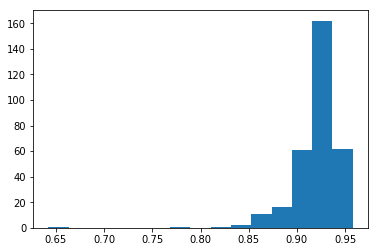

In [198]:
plt.hist(model_scores_grouped_suc, 15)

In [171]:
output_to_score_suc(5, None)

0.9933071490757153

In [131]:
torch.tensor(0).unsqueeze(0).unsqueeze(0)

tensor([[0]])

In [135]:
torch.tensor(0).view(1, 1)

tensor([[0]])

In [220]:
wrong_train = list(filter(lambda de: de.target_idx != de.click_idx, train_data.entries))

In [226]:
correct_train_sample = list(filter(lambda de: de.target_idx == de.click_idx, train_data.entries))[:len(wrong_train)]

In [227]:
len(correct_train_sample)

1782

In [225]:
len(train_data.data) - sum(train_data.data.numOutcome)

1782.0

In [621]:
train = False
model_file_suc_col = "../model/literal_listener_predict_success_flipped_colors_5epoch_endings_tkn_v2.params"

model_suc_col = LiteralListenerPredictSuccess(PredictSuccessColor, num_epochs=5, criterion=nn.BCEWithLogitsLoss,
                                              optimizer=torch.optim.Adam, lr=0.004)
model_suc_col.init_model(embed_dim = embed_dim, hidden_dim = hidden_dim, 
                     vocab_size = feature_handler_suc.caption_featurizer.caption_indexer.size,
                     color_in_dim = 54, color_hidden_dim=100)


In [622]:
if train:
    print("Training model and saving to {}:".format(model_file_suc_col))
    model_suc_col.fit(train_features, train_targets)
    model_suc_col.save_model(model_file_suc_col)
else:
    print("Loading pretrained model")
    model_suc_col.load_model(model_file_suc_col)

Loading pretrained model


In [561]:
color_phi_fourier(train_data[0].colors[0].hsv_norm, space="hsv_norm")

array([ 1.        , -0.955793  ,  0.82708055, -0.94611347,  0.809068  ,
       -0.6004896 ,  0.7902614 , -0.5751473 ,  0.30918208, -0.6946584 ,
        0.8754645 , -0.9788674 ,  0.89017326, -0.98479265,  0.99234265,
       -0.98975146,  0.9879867 , -0.8988701 , -0.0348995 , -0.2605045 ,
        0.53287625, -0.29061916,  0.55912095, -0.77818865,  0.5848169 ,
       -0.7974792 ,  0.93963325,  0.        , -0.29404032,  0.56208336,
       -0.3238353 ,  0.587715  , -0.79963255,  0.6127699 , -0.8180499 ,
        0.9510029 ,  0.7193398 , -0.4832824 ,  0.20449606, -0.45562217,
        0.17373364,  0.12351536,  0.14280072,  0.1545389 , -0.43821514,
       -0.99939084,  0.96547264, -0.8461932 ,  0.9568388 , -0.8290861 ,
        0.6280306 , -0.81116533,  0.6033464 , -0.34218323], dtype=float32)

In [557]:
train_features[0][1]

array([[-0.3815018 ,  0.18612514,  0.01698581,  0.17215896,  0.03117754,
        -0.23321848,  0.04536299, -0.24699901,  0.43837115,  0.81485736,
        -0.9154749 ,  0.9780505 , -0.9210946 ,  0.9809098 , -0.99996394,
         0.98357147, -0.9997426 ,  0.97437006,  0.74810785, -0.5979992 ,
         0.42304116, -0.5865613 ,  0.41013584, -0.21666741,  0.3971479 ,
        -0.2027873 ,  0.        , -0.9243681 ,  0.98252606, -0.99985576,
         0.98506916, -0.99951386,  0.9724244 , -0.99897057,  0.9690157 ,
        -0.89879405, -0.5796615 ,  0.40237504, -0.20836814,  0.38933888,
        -0.19446324, -0.00849321, -0.18051915, -0.02268733,  0.22495106,
         0.66357714, -0.8014967 ,  0.90611047, -0.8099048 ,  0.91202444,
        -0.97624546,  0.91775465, -0.97922283,  1.        ],
       [-0.9583226 ,  0.91495967, -0.8571673 ,  0.91283417, -0.8544588 ,
         0.78260815, -0.85172695,  0.77933794, -0.6946584 ,  0.6238796 ,
        -0.7169106 ,  0.7986355 , -0.72055113,  0.80177563, -0.

In [436]:
if train:
    print("Training model and saving to {}:".format(model_file_suc_col))
    model_suc_col.fit(train_features, train_targets)
    model_suc_col.save_model(model_file_suc_col)
else:
    print("Loading pretrained model")
    model_suc_col.load_model(model_file_suc_col)

Training model and saving to ../model/literal_listener_predict_success_colors_30epoch_endings_tkn.params:
---EPOCH 0---
0m 0s (0:0 0.00%) 0.0007
0m 8s (0:1000 3.60%) 0.6873
0m 16s (0:2000 7.20%) 0.6647
0m 24s (0:3000 10.80%) 0.6611
0m 33s (0:4000 14.41%) 0.6599
0m 41s (0:5000 18.01%) 0.6490
0m 49s (0:6000 21.61%) 0.6596
0m 57s (0:7000 25.21%) 0.6434
1m 6s (0:8000 28.81%) 0.6400
1m 14s (0:9000 32.41%) 0.6483
1m 22s (0:10000 36.02%) 0.6207
1m 30s (0:11000 39.62%) 0.6268
1m 39s (0:12000 43.22%) 0.6259
1m 47s (0:13000 46.82%) 0.6204
1m 56s (0:14000 50.42%) 0.6232
2m 4s (0:15000 54.02%) 0.6236
2m 13s (0:16000 57.62%) 0.6091
2m 22s (0:17000 61.23%) 0.6131
2m 30s (0:18000 64.83%) 0.5998
2m 39s (0:19000 68.43%) 0.6188
2m 48s (0:20000 72.03%) 0.5924
2m 56s (0:21000 75.63%) 0.6140
3m 5s (0:22000 79.23%) 0.6027
3m 13s (0:23000 82.84%) 0.5912
3m 22s (0:24000 86.44%) 0.5993
3m 31s (0:25000 90.04%) 0.5881
3m 39s (0:26000 93.64%) 0.5986
3m 48s (0:27000 97.24%) 0.5893
---EPOCH 1---
3m 54s (1:0 0.00%) 

54m 14s (9:5000 18.01%) 0.3624
54m 23s (9:6000 21.61%) 0.3154
54m 31s (9:7000 25.21%) 0.3438
54m 40s (9:8000 28.81%) 0.3303
54m 49s (9:9000 32.41%) 0.3244
54m 57s (9:10000 36.02%) 0.3591
55m 6s (9:11000 39.62%) 0.3363
55m 15s (9:12000 43.22%) 0.3770
55m 23s (9:13000 46.82%) 0.3555
55m 32s (9:14000 50.42%) 0.3451
55m 42s (9:15000 54.02%) 0.3352
55m 52s (9:16000 57.62%) 0.3027
56m 2s (9:17000 61.23%) 0.3142
56m 11s (9:18000 64.83%) 0.3028
56m 20s (9:19000 68.43%) 0.3330
56m 29s (9:20000 72.03%) 0.2956
56m 38s (9:21000 75.63%) 0.3286
56m 47s (9:22000 79.23%) 0.3443
56m 57s (9:23000 82.84%) 0.3021
57m 8s (9:24000 86.44%) 0.3798
57m 18s (9:25000 90.04%) 0.2887
57m 28s (9:26000 93.64%) 0.3304
57m 38s (9:27000 97.24%) 0.3828
---EPOCH 10---
57m 45s (10:0 0.00%) 0.0015
57m 55s (10:1000 3.60%) 0.3148
58m 6s (10:2000 7.20%) 0.3016
58m 20s (10:3000 10.80%) 0.3390
58m 30s (10:4000 14.41%) 0.3748
58m 39s (10:5000 18.01%) 0.3652
58m 50s (10:6000 21.61%) 0.2996
59m 2s (10:7000 25.21%) 0.3502
59m 11s (

93m 39s (18:4000 14.41%) 0.3257
93m 47s (18:5000 18.01%) 0.2787
93m 56s (18:6000 21.61%) 0.2258
94m 5s (18:7000 25.21%) 0.3066
94m 13s (18:8000 28.81%) 0.2229
94m 22s (18:9000 32.41%) 0.2539
94m 31s (18:10000 36.02%) 0.2528
94m 41s (18:11000 39.62%) 0.2704
94m 53s (18:12000 43.22%) 0.2661
95m 2s (18:13000 46.82%) 0.2802
95m 13s (18:14000 50.42%) 0.2469
95m 23s (18:15000 54.02%) 0.2639
95m 33s (18:16000 57.62%) 0.2082
95m 43s (18:17000 61.23%) 0.2495
95m 53s (18:18000 64.83%) 0.2415
96m 1s (18:19000 68.43%) 0.2568
96m 11s (18:20000 72.03%) 0.2411
96m 20s (18:21000 75.63%) 0.2499
96m 29s (18:22000 79.23%) 0.2407
96m 38s (18:23000 82.84%) 0.1974
96m 46s (18:24000 86.44%) 0.2826
96m 55s (18:25000 90.04%) 0.2273
97m 4s (18:26000 93.64%) 0.2498
97m 12s (18:27000 97.24%) 0.2967
---EPOCH 19---
97m 19s (19:0 0.00%) 0.0000
97m 28s (19:1000 3.60%) 0.2397
97m 36s (19:2000 7.20%) 0.2135
97m 45s (19:3000 10.80%) 0.2536
97m 54s (19:4000 14.41%) 0.3164
98m 2s (19:5000 18.01%) 0.2685
98m 11s (19:6000 2

130m 18s (26:24000 86.44%) 0.2363
130m 28s (26:25000 90.04%) 0.1764
130m 37s (26:26000 93.64%) 0.1908
130m 47s (26:27000 97.24%) 0.2096
---EPOCH 27---
130m 54s (27:0 0.00%) 0.0000
131m 4s (27:1000 3.60%) 0.1901
131m 13s (27:2000 7.20%) 0.1692
131m 22s (27:3000 10.80%) 0.2077
131m 31s (27:4000 14.41%) 0.2568
131m 41s (27:5000 18.01%) 0.1950
131m 50s (27:6000 21.61%) 0.1503
132m 0s (27:7000 25.21%) 0.2341
132m 10s (27:8000 28.81%) 0.1750
132m 21s (27:9000 32.41%) 0.1812
132m 31s (27:10000 36.02%) 0.1991
132m 40s (27:11000 39.62%) 0.2122
132m 50s (27:12000 43.22%) 0.1757
132m 59s (27:13000 46.82%) 0.2059
133m 8s (27:14000 50.42%) 0.1963
133m 18s (27:15000 54.02%) 0.2174
133m 27s (27:16000 57.62%) 0.1867
133m 37s (27:17000 61.23%) 0.1779
133m 46s (27:18000 64.83%) 0.1670
133m 56s (27:19000 68.43%) 0.1891
134m 5s (27:20000 72.03%) 0.1771
134m 14s (27:21000 75.63%) 0.1756
134m 23s (27:22000 79.23%) 0.1938
134m 32s (27:23000 82.84%) 0.1519
134m 41s (27:24000 86.44%) 0.2343
134m 50s (27:25000 

In [383]:
assess_targets_tgt_suc_col, model_outputs_suc_col, model_scores_suc_col, true_scores_grouped_suc_col, model_scores_grouped_suc_col =\
    evaluate_model(dev_data, feature_handler, model_suc_col, output_to_score_suc, score_model, accuracy=False)

(0.28410669491809376, 2.6781346038307877e-07)


In [384]:
metrics.roc_auc_score(assess_targets_tgt_suc_col, model_scores_suc_col)

0.5699285942962217

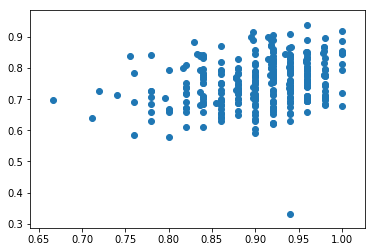

In [386]:
plt.scatter(true_scores_grouped_suc_col, model_scores_grouped_suc_col)

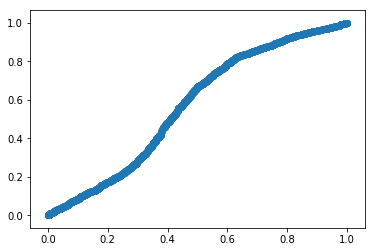

In [385]:
fpr, tpr, _ = metrics.roc_curve(assess_targets_tgt_suc_col, model_scores_suc_col, pos_label=1)
plt.scatter(fpr, tpr) # fpr and tpr from metrics.roc_score

In [623]:
assess_targets_tgt_suc_col_synth, model_outputs_suc_col_synth, model_scores_suc_col_synth, true_scores_grouped_suc_col_synth, model_scores_grouped_suc_col_synth =\
    evaluate_model(dev_data_synth, feature_handler_suc, model_suc_col, output_to_score_suc, score_model, accuracy=False)


(0.08457071143115714, 0.05487572966912681)


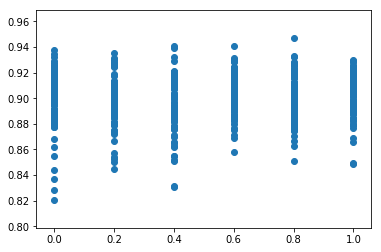

In [624]:
plt.scatter(true_scores_grouped_suc_col_synth, model_scores_grouped_suc_col_synth)

6000) Game: synth-120 Round: 1
Grey lol


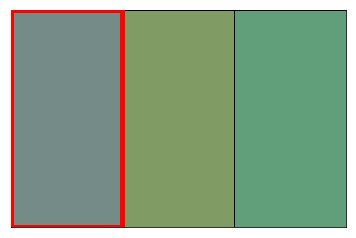

In [520]:
dev_data_synth.display_game(6000)

In [500]:
assess_targets_tgt_suc_col_synth, model_outputs_suc_col_synth, model_scores_suc_col_synth, true_scores_grouped_suc_col_synth, model_scores_grouped_suc_col_synth =\
    evaluate_model(dev_data_synth, feature_handler_synth, model_suc_col, output_to_score_suc, score_model, accuracy=False)

(-0.005838513219130491, 0.8947430432318636)


this seems to imply that the model that is just predicting listener success is actually not using any information from the color!

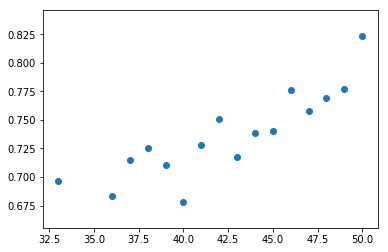

(0.8597547157487094, 1.9588688051440834e-05)

In [427]:
true_scores_grouped_rounded_suc_col = [int(50*round_partial(score, 1/50)) for score in true_scores_grouped_suc_col]
suc_col_df = pd.DataFrame({'model_scores': model_scores_grouped_suc_col, 'true_scores': true_scores_grouped_rounded_suc_col})
suc_col_scores_series = suc_col_df.groupby('true_scores').mean()['model_scores']
plt.scatter(suc_col_scores_series.index, suc_col_scores_series.values)
plt.show()
stats.pearsonr(suc_col_scores_series.index, suc_col_scores_series.values)

In [437]:
assess_targets_tgt_suc_col, model_outputs_suc_col, model_scores_suc_col, true_scores_grouped_suc_col, model_scores_grouped_suc_col =\
    evaluate_model(dev_data, feature_handler, model_suc_col, output_to_score_suc, score_model, accuracy=False)

(0.2581758976793939, 3.1970940807524333e-06)


In [438]:
metrics.roc_auc_score(assess_targets_tgt_suc_col, model_scores_suc_col)

0.5217617003212025

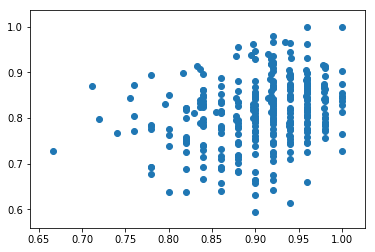

In [439]:
plt.scatter(true_scores_grouped_suc_col, model_scores_grouped_suc_col)

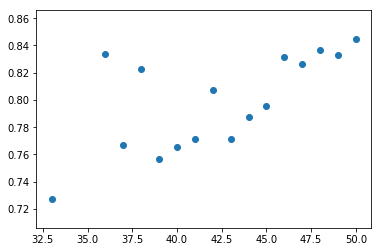

(0.6616253797339549, 0.005246649038491157)

In [440]:
true_scores_grouped_rounded_suc_col = [int(50*round_partial(score, 1/50)) for score in true_scores_grouped_suc_col]
suc_col_df = pd.DataFrame({'model_scores': model_scores_grouped_suc_col, 'true_scores': true_scores_grouped_rounded_suc_col})
suc_col_scores_series = suc_col_df.groupby('true_scores').mean()['model_scores']
plt.scatter(suc_col_scores_series.index, suc_col_scores_series.values)
plt.show()
stats.pearsonr(suc_col_scores_series.index, suc_col_scores_series.values)

In [459]:
pd.Series(assess_targets_tgt_suc_col, index=dev_data.data.index)

0        1
1        1
2        1
3        1
4        1
5        1
6        1
7        1
8        1
9        1
10       1
11       1
12       1
13       1
14       0
15       0
16       1
17       1
18       0
19       1
20       1
21       1
22       1
23       1
24       0
25       1
26       1
27       1
28       1
29       0
        ..
15640    1
15641    1
15642    1
15643    1
15644    1
15645    1
15646    1
15647    1
15648    1
15649    1
15650    1
15651    1
15652    1
15653    1
15654    1
15655    1
15656    1
15657    1
15658    1
15659    1
15660    1
15661    1
15662    1
15663    1
15664    1
15665    1
15666    1
15667    1
15668    1
15669    1
Length: 15670, dtype: int64

In [457]:
dev_data.data['condition']

0        split
1        split
2          far
3        split
4          far
5        close
6          far
7          far
8        close
9          far
10         far
11       split
12       close
13         far
14       split
15       close
16       split
17         far
18       split
19         far
20       split
21         far
22         far
23         far
24       close
25       close
26       close
27       close
28       close
29       close
         ...  
15640    split
15641    split
15642      far
15643    close
15644    close
15645      far
15646      far
15647    close
15648    close
15649    close
15650    split
15651      far
15652      far
15653    split
15654    close
15655    split
15656      far
15657    split
15658      far
15659    split
15660    close
15661    close
15662    split
15663    close
15664    close
15665      far
15666      far
15667      far
15668    split
15669      far
Name: condition, Length: 15670, dtype: object

In [467]:
suc_col_score_df = pd.concat([dev_data.data.gameid, pd.Series(assess_targets_tgt_suc_col, index=dev_data.data.index, name="true_score"), 
           pd.Series(model_scores_suc_col, index=dev_data.data.index, name="model_score"), dev_data.data['condition']], axis=1)

In [477]:
suc_col_score_close = suc_col_score_df.groupby(["condition", "gameid"]).mean().xs('close', level='condition')  #index.get_level_values('condition')

In [482]:
suc_col_score_close[suc_col_score_close['true_score'] < 0.5]

,true_score,model_score
gameid,,
1925-1,0.437500,0.484696
3332-5,0.470588,0.516032
7286-9,0.470588,0.709436


10418) Game: 1925-1 Round: 1
red


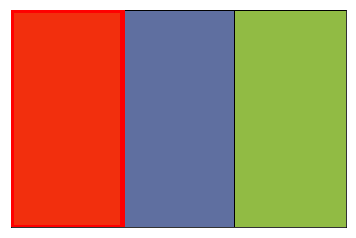

10419) Game: 1925-1 Round: 2
tan


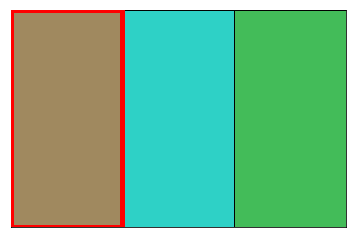

10420) Game: 1925-1 Round: 3
gold


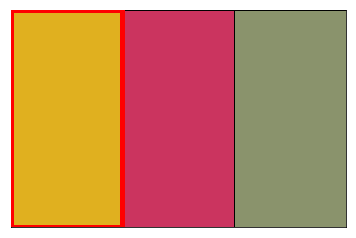

10421) Game: 1925-1 Round: 4
blue


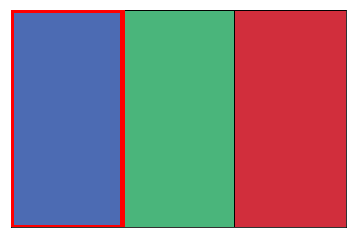

10422) Game: 1925-1 Round: 5
blue-not pink, not purple


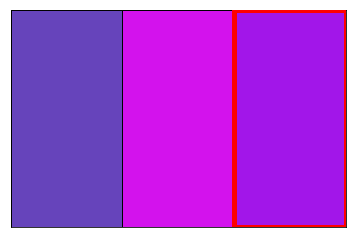

10423) Game: 1925-1 Round: 7
pick the darker of the two blue shades


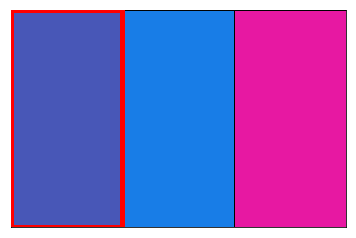

10424) Game: 1925-1 Round: 8
red


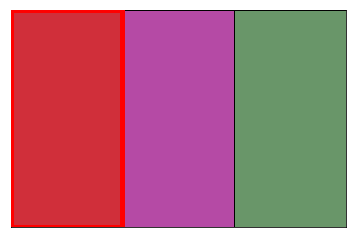

10425) Game: 1925-1 Round: 9
bright yellow


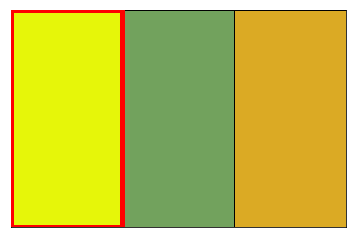

10426) Game: 1925-1 Round: 11
so one has a greenish tint. not that one


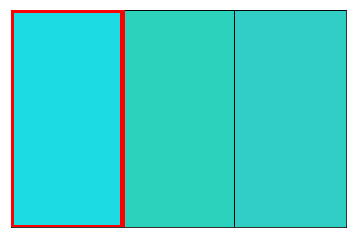

10427) Game: 1925-1 Round: 12
pale blue


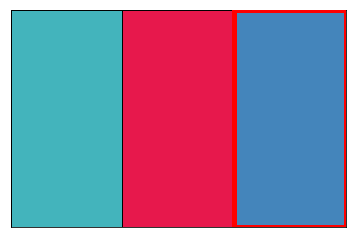

10428) Game: 1925-1 Round: 13
not neon green, and not the greenish/brownish


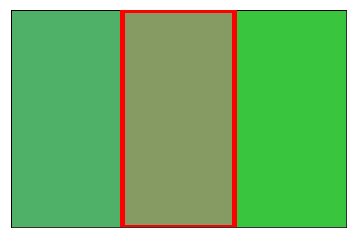

10429) Game: 1925-1 Round: 14
the brighter blue ~ what are you doing?


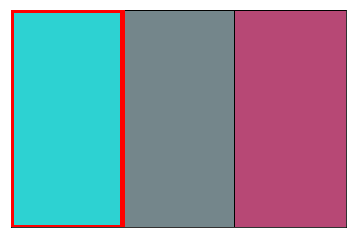

10430) Game: 1925-1 Round: 15
neon green/yellow


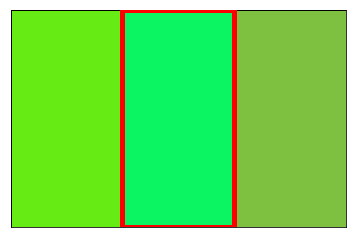

10431) Game: 1925-1 Round: 16
slate blue ~ i'd appreciate it if you could pay attention


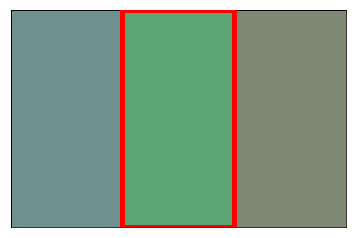

10432) Game: 1925-1 Round: 17
pink/purple. not light purple. not blue/purple


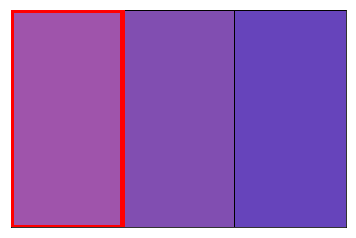

10433) Game: 1925-1 Round: 18
blue


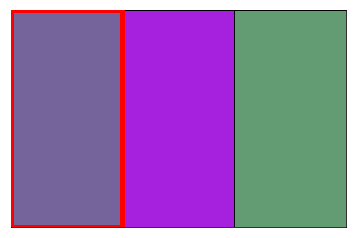

10434) Game: 1925-1 Round: 19
yellow ~ can you just exit please


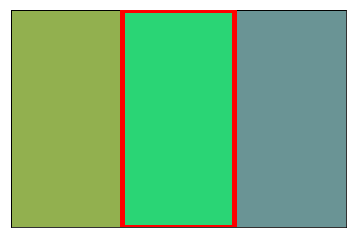

10435) Game: 1925-1 Round: 20
the more purple one. ~ not blue ~ not the dullish purple


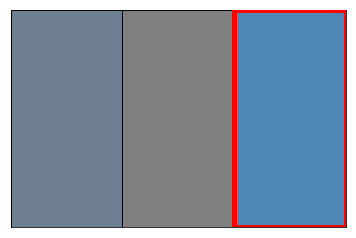

10436) Game: 1925-1 Round: 21
hot pink


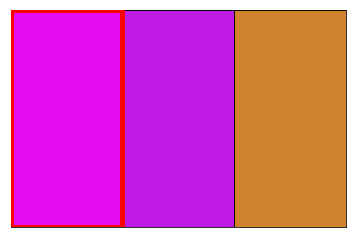

10437) Game: 1925-1 Round: 22
what?


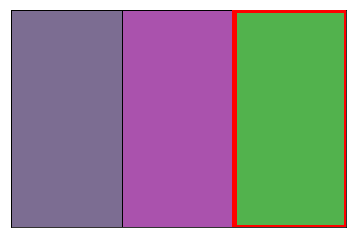

10438) Game: 1925-1 Round: 23
blue


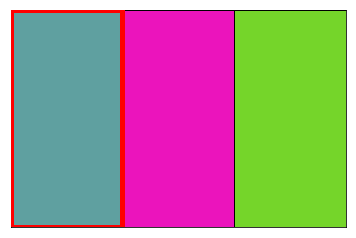

10439) Game: 1925-1 Round: 24
yellow


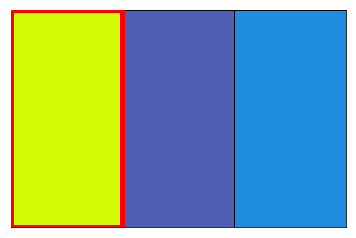

10440) Game: 1925-1 Round: 25
the darkest blue


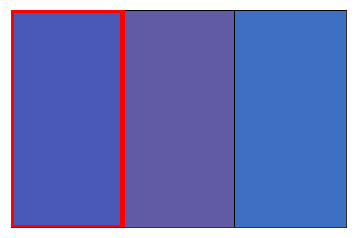

10441) Game: 1925-1 Round: 26
pink


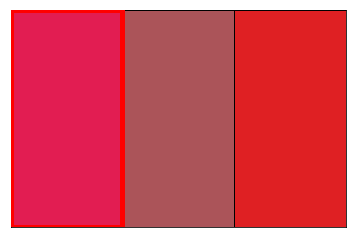

10442) Game: 1925-1 Round: 27
sage/seaweed green


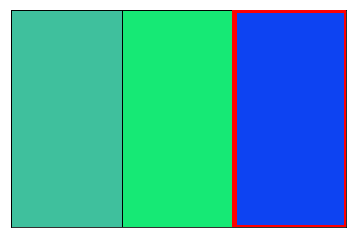

10443) Game: 1925-1 Round: 28
darkest blue


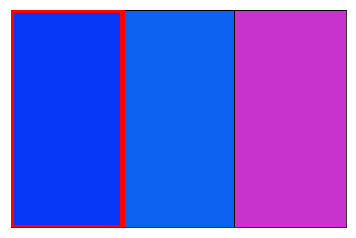

10444) Game: 1925-1 Round: 29
yellow


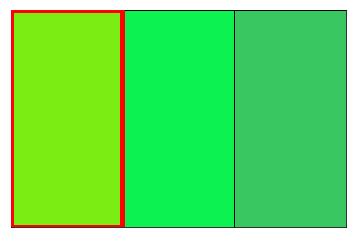

10445) Game: 1925-1 Round: 30
the most brown shade


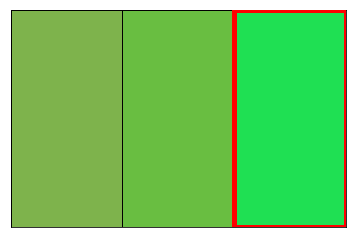

10446) Game: 1925-1 Round: 31
tan


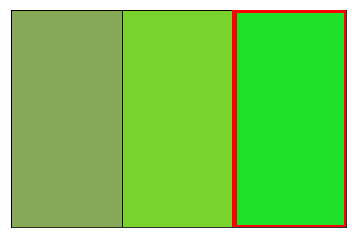

10447) Game: 1925-1 Round: 32
darkest purple


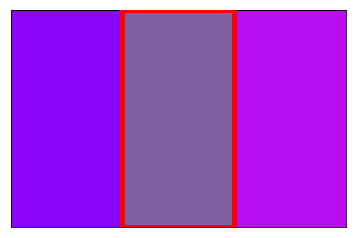

10448) Game: 1925-1 Round: 33
medium blue


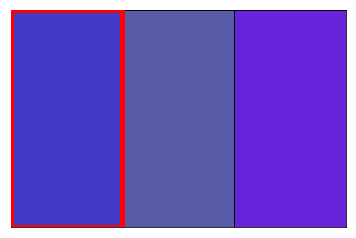

10449) Game: 1925-1 Round: 34
blue


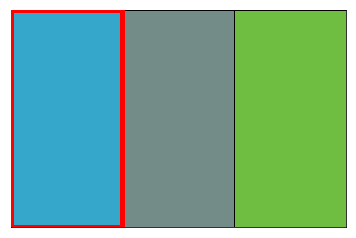

10450) Game: 1925-1 Round: 35
purple


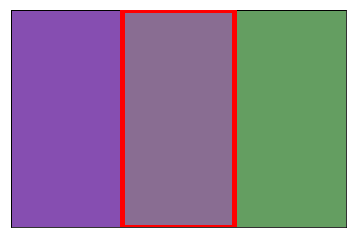

10451) Game: 1925-1 Round: 36
bright green


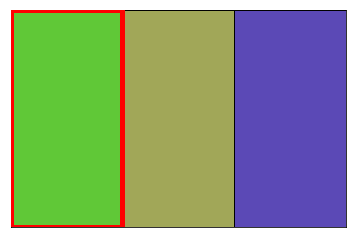

10452) Game: 1925-1 Round: 37
pink


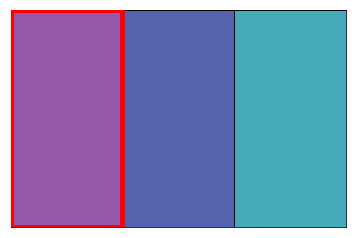

10453) Game: 1925-1 Round: 38
blue


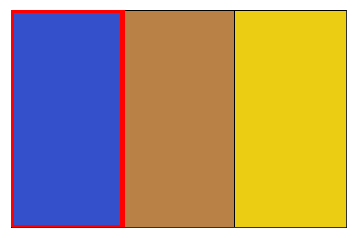

10454) Game: 1925-1 Round: 39
gold


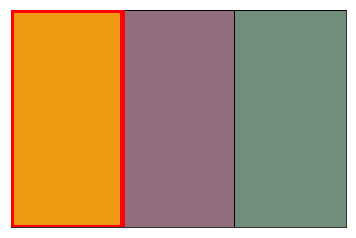

10455) Game: 1925-1 Round: 40
light green


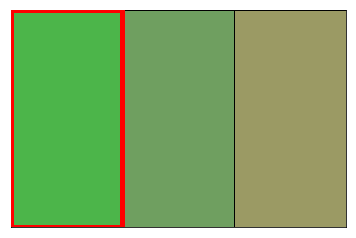

10456) Game: 1925-1 Round: 41
blue


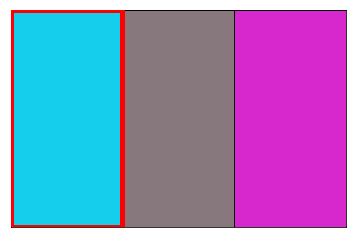

10457) Game: 1925-1 Round: 42
tan


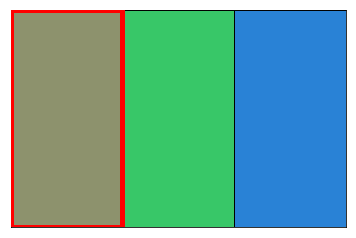

10458) Game: 1925-1 Round: 43
orange. not the peach one


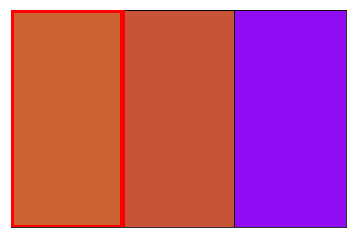

10459) Game: 1925-1 Round: 44
teal


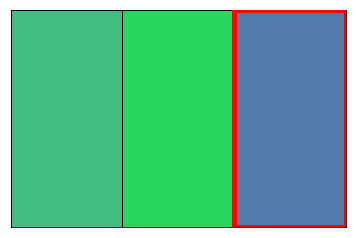

10460) Game: 1925-1 Round: 45
orange


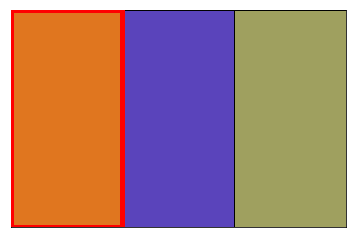

10461) Game: 1925-1 Round: 46
the brightest


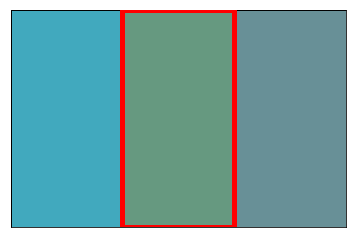

10462) Game: 1925-1 Round: 47
sage


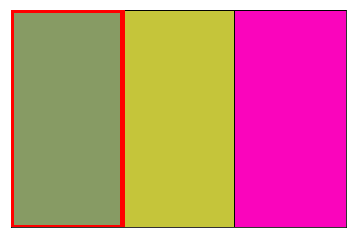

10463) Game: 1925-1 Round: 48
purple


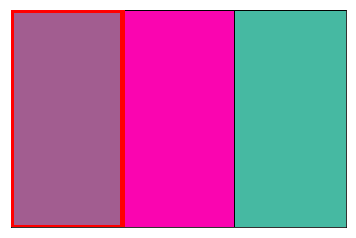

10464) Game: 1925-1 Round: 49
lightest/brightest


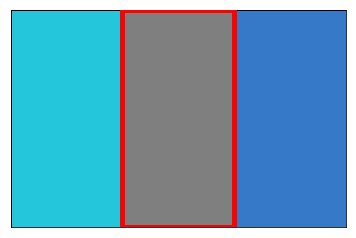

10465) Game: 1925-1 Round: 50
sage


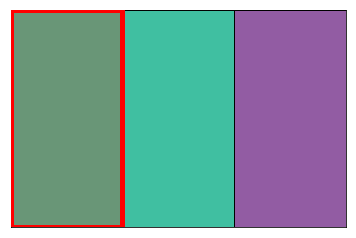

In [483]:
dev_data.display_game_for_gameid('1925-1')

2882) Game: 3332-5 Round: 1
Hello ~ Yellow


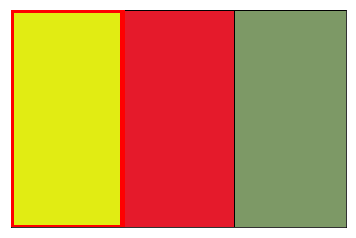

2883) Game: 3332-5 Round: 2
Darkest one


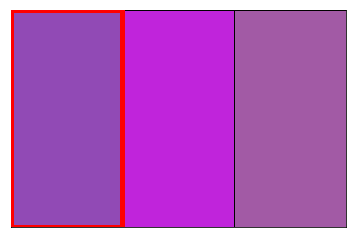

2884) Game: 3332-5 Round: 3
Blue


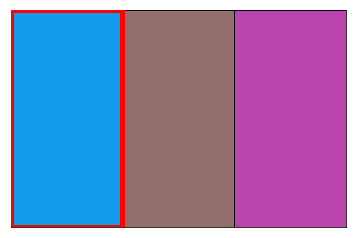

2885) Game: 3332-5 Round: 4
Green


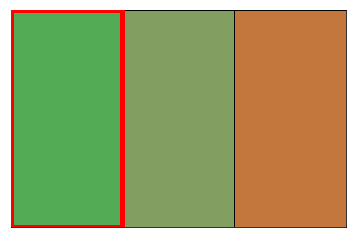

2886) Game: 3332-5 Round: 5
Pink


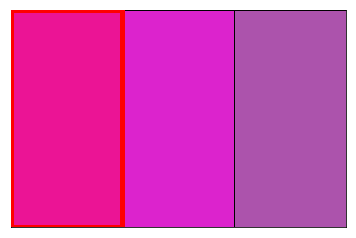

2887) Game: 3332-5 Round: 6
Red


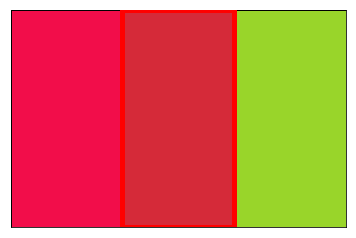

2888) Game: 3332-5 Round: 7
Darkest one


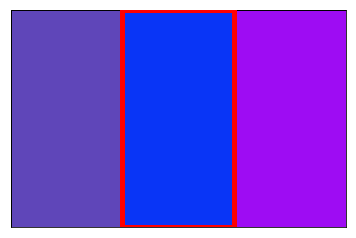

2889) Game: 3332-5 Round: 8
Green


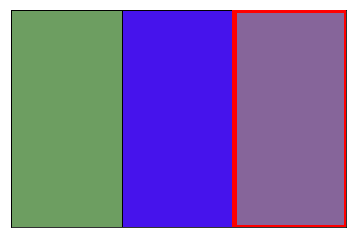

2890) Game: 3332-5 Round: 9
Olive


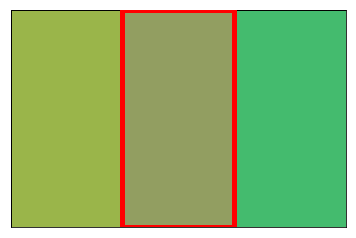

2891) Game: 3332-5 Round: 10
Green medium pale


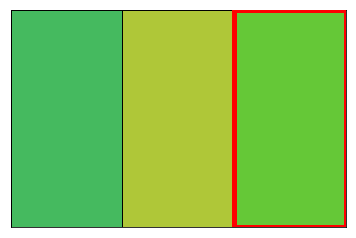

2892) Game: 3332-5 Round: 11
Grey dark


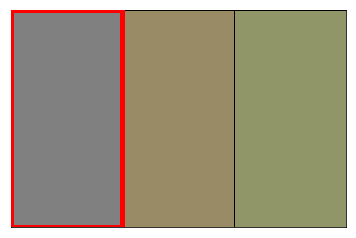

2893) Game: 3332-5 Round: 12
Green


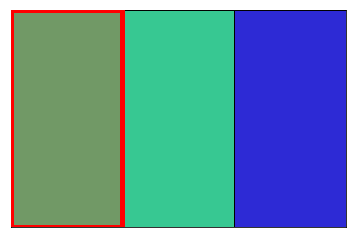

2894) Game: 3332-5 Round: 13
Blue


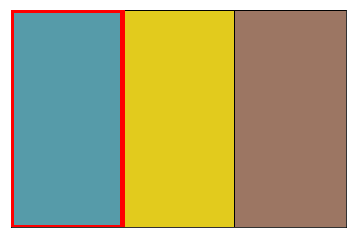

2895) Game: 3332-5 Round: 14
Red


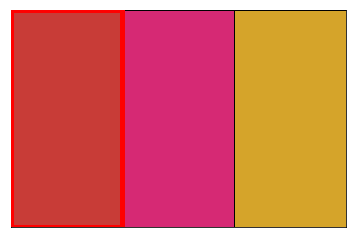

2896) Game: 3332-5 Round: 15
Green


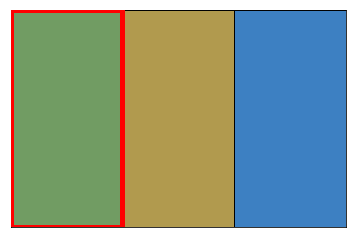

2897) Game: 3332-5 Round: 16
Yellow


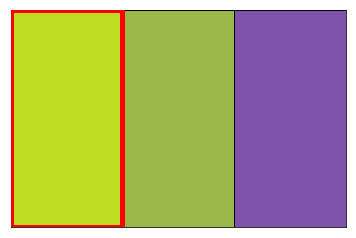

2898) Game: 3332-5 Round: 17
Pink


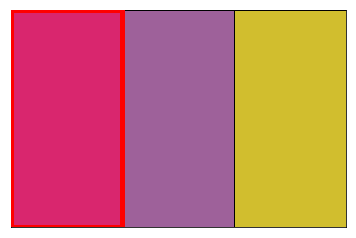

2899) Game: 3332-5 Round: 18
Blue pale


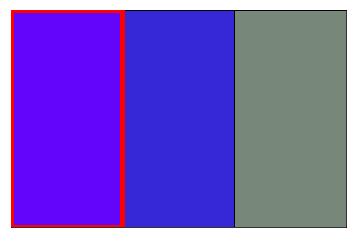

2900) Game: 3332-5 Round: 19
Brown


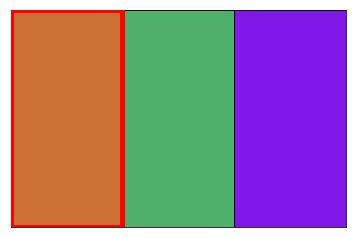

2901) Game: 3332-5 Round: 20
Grey


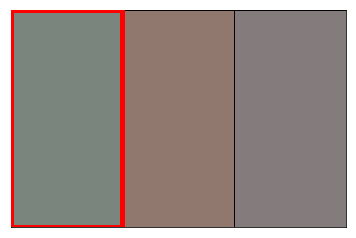

2902) Game: 3332-5 Round: 21
Blue


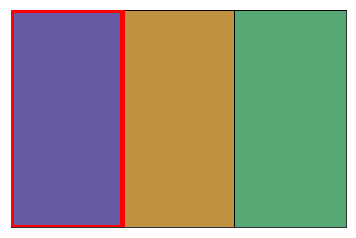

2903) Game: 3332-5 Round: 22
Pink


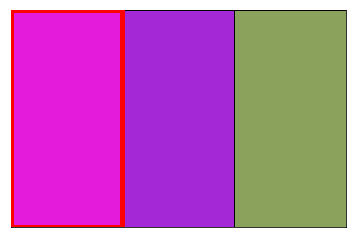

2904) Game: 3332-5 Round: 23
Green pale the lightest one


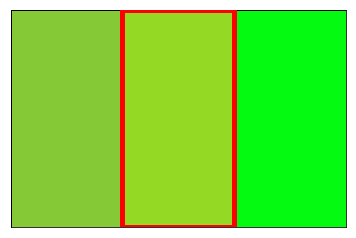

2905) Game: 3332-5 Round: 24
The darkest one more grey


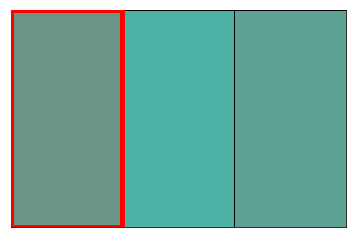

2906) Game: 3332-5 Round: 25
Tan


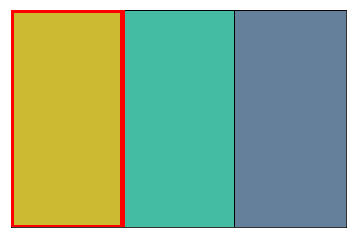

2907) Game: 3332-5 Round: 26
Bluish purple


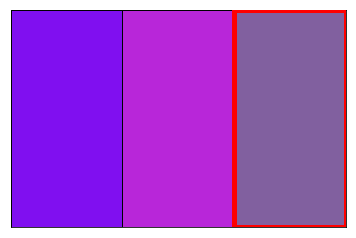

2908) Game: 3332-5 Round: 27
Grey


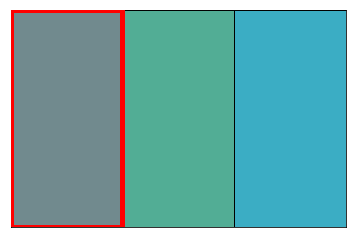

2909) Game: 3332-5 Round: 28
Blue


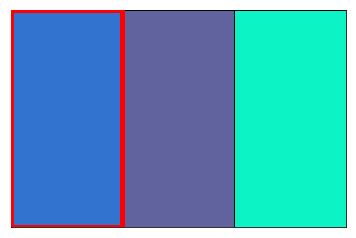

2910) Game: 3332-5 Round: 29
Olive green


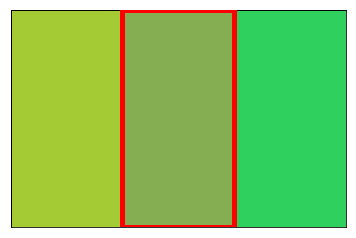

2911) Game: 3332-5 Round: 30
Green


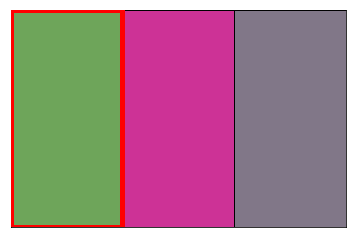

2912) Game: 3332-5 Round: 31
Brown


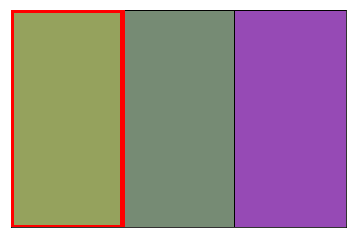

2913) Game: 3332-5 Round: 32
Green olive


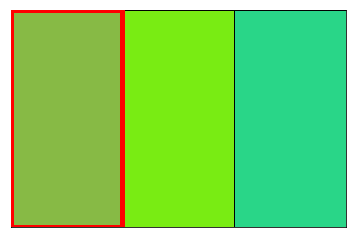

2914) Game: 3332-5 Round: 33
Green army dark


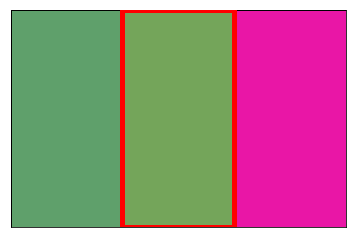

2915) Game: 3332-5 Round: 34
Purple dark


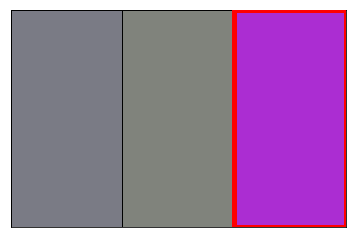

2916) Game: 3332-5 Round: 35
Blue


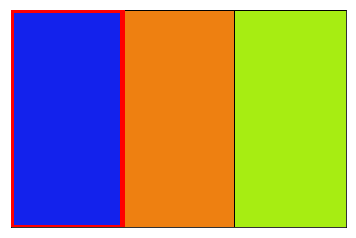

2917) Game: 3332-5 Round: 36
Purple


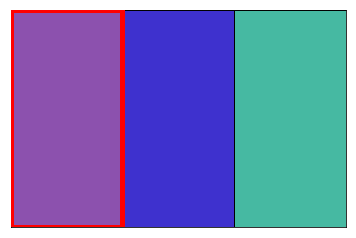

2918) Game: 3332-5 Round: 37
Grey


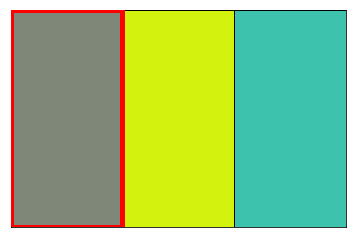

2919) Game: 3332-5 Round: 38
Purple middle color not bright not dark


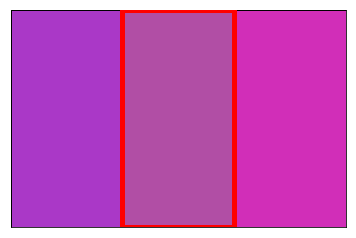

2920) Game: 3332-5 Round: 39
Pink


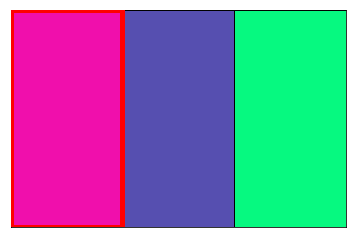

2921) Game: 3332-5 Round: 40
Yellow


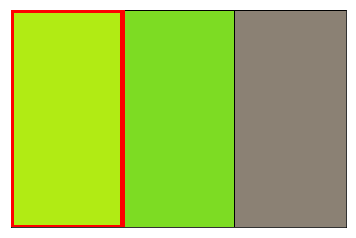

2922) Game: 3332-5 Round: 41
Grey


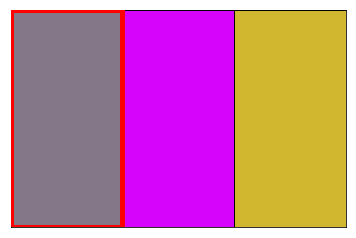

2923) Game: 3332-5 Round: 42
Brown


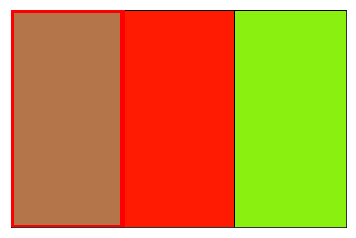

2924) Game: 3332-5 Round: 43
Purple


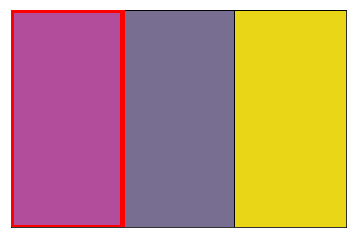

2925) Game: 3332-5 Round: 44
Blue grey


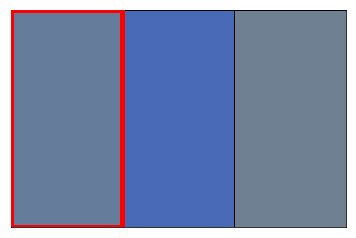

2926) Game: 3332-5 Round: 45
purple


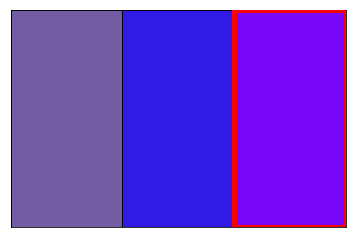

2927) Game: 3332-5 Round: 46
Purple


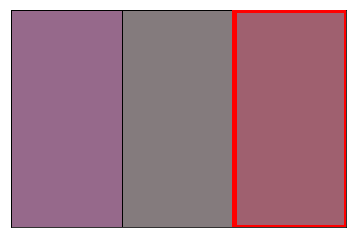

2928) Game: 3332-5 Round: 47
Teal


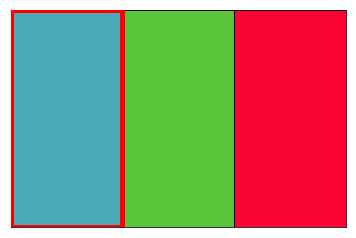

2929) Game: 3332-5 Round: 48
Brown


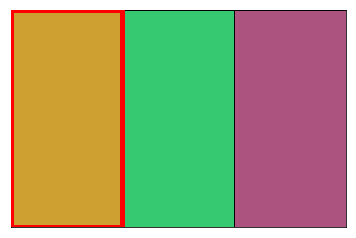

2930) Game: 3332-5 Round: 49
Grey


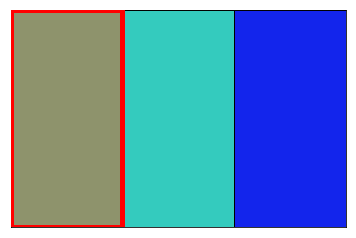

2931) Game: 3332-5 Round: 50
Purple


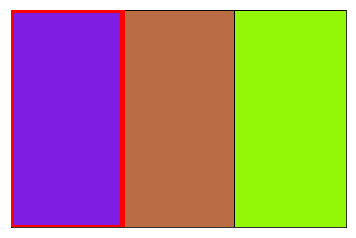

In [484]:
dev_data.display_game_for_gameid('3332-5')

8581) Game: 7286-9 Round: 1
the darkest blue


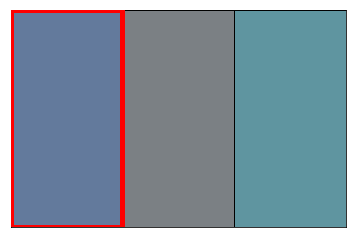

8582) Game: 7286-9 Round: 2
the ugliest color


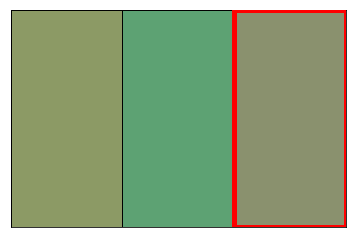

8583) Game: 7286-9 Round: 3
brightest


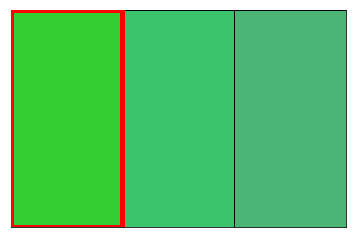

8584) Game: 7286-9 Round: 4
blueish


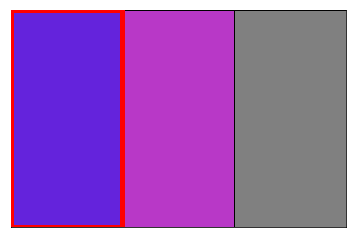

8585) Game: 7286-9 Round: 5
ugliest


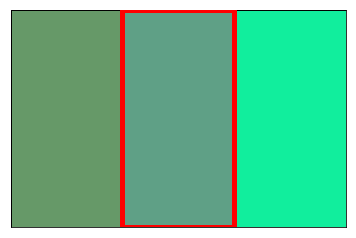

8586) Game: 7286-9 Round: 6
purple


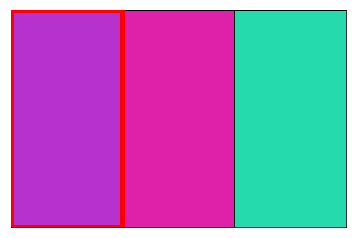

8587) Game: 7286-9 Round: 7
pinkish/red


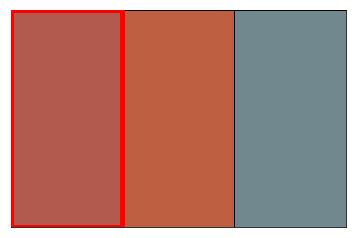

8588) Game: 7286-9 Round: 8
very bright


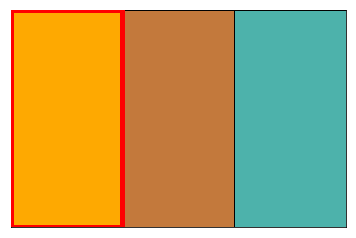

8589) Game: 7286-9 Round: 9
blueish/green


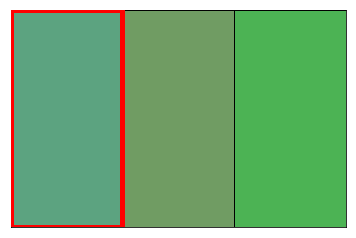

8590) Game: 7286-9 Round: 10
red


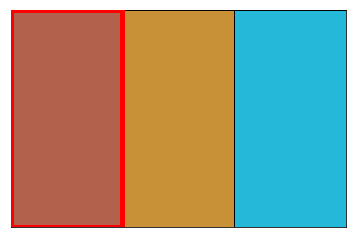

8591) Game: 7286-9 Round: 11
green


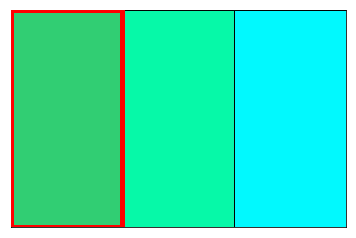

8592) Game: 7286-9 Round: 12
darker blue


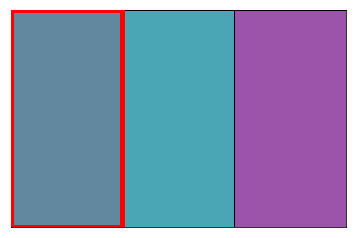

8593) Game: 7286-9 Round: 13
yellow


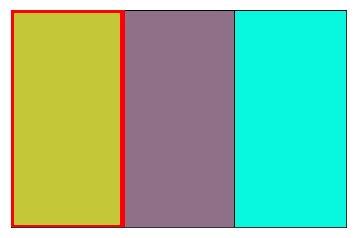

8594) Game: 7286-9 Round: 14
purple


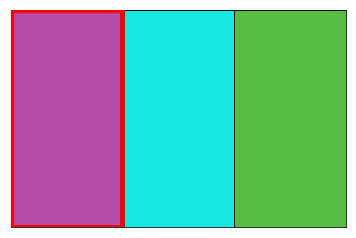

8595) Game: 7286-9 Round: 15
orange


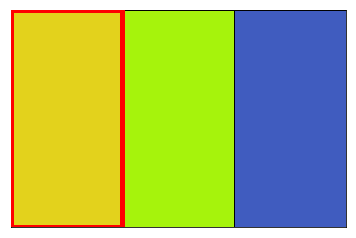

8596) Game: 7286-9 Round: 16
this is boring as watching paint dry. blue


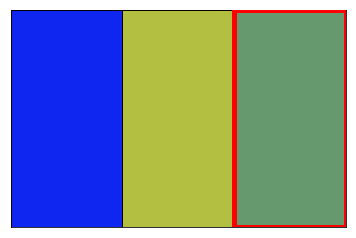

8597) Game: 7286-9 Round: 17
darker grey


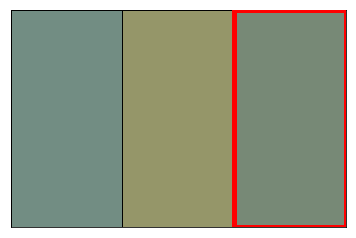

8598) Game: 7286-9 Round: 18
darkest color


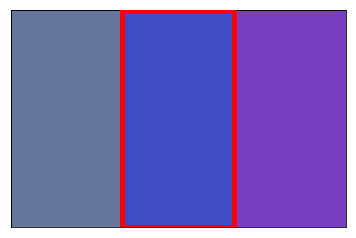

8599) Game: 7286-9 Round: 19
that's bright kniucle head. yellow


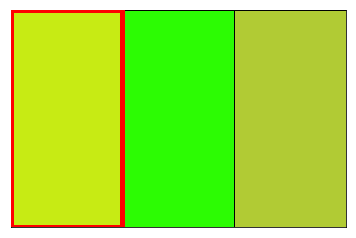

8600) Game: 7286-9 Round: 20
uh. the one that doesn't fit in teh group


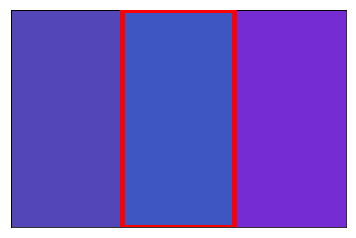

8601) Game: 7286-9 Round: 21
orangeish


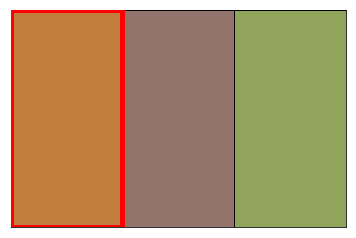

8602) Game: 7286-9 Round: 22
light purple


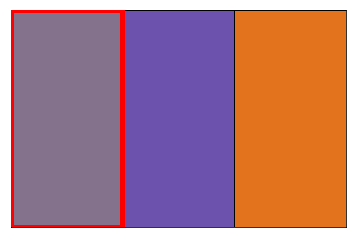

8603) Game: 7286-9 Round: 23
cement color


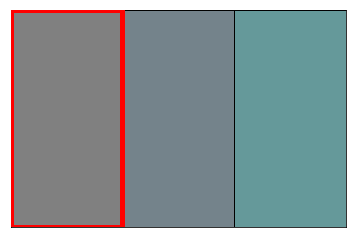

8604) Game: 7286-9 Round: 24
nice job, knuckle dragger. how about yellow


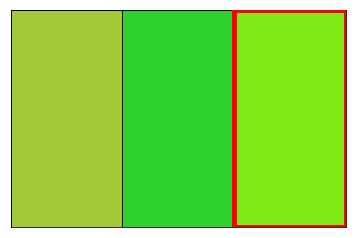

8605) Game: 7286-9 Round: 25
purple dark


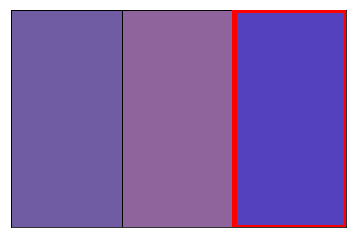

8606) Game: 7286-9 Round: 26
blue


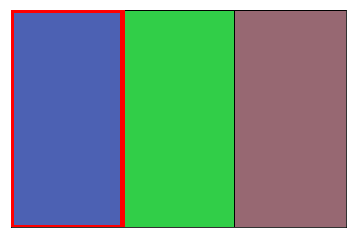

8607) Game: 7286-9 Round: 27
uh ~ bright green


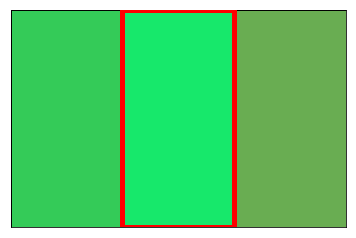

8608) Game: 7286-9 Round: 28
mustard yellow


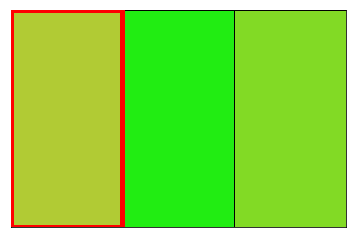

8609) Game: 7286-9 Round: 29
dark pink


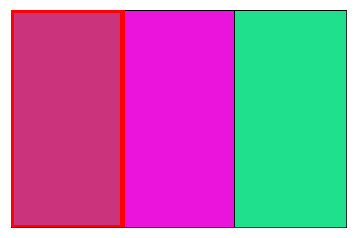

8610) Game: 7286-9 Round: 30
dark purple


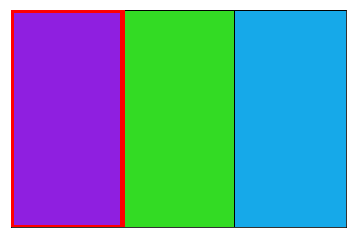

8611) Game: 7286-9 Round: 31
one that sticks out


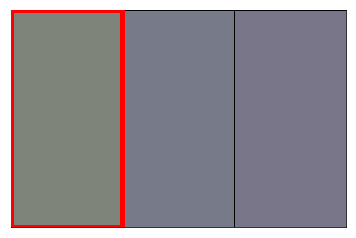

8612) Game: 7286-9 Round: 32
brighter pink


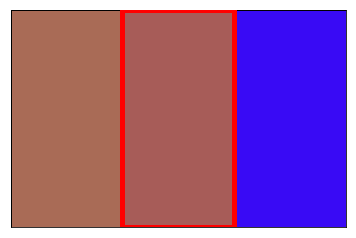

8613) Game: 7286-9 Round: 33
one that sticks out


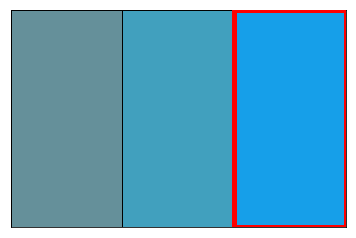

8614) Game: 7286-9 Round: 34
one that stiks out


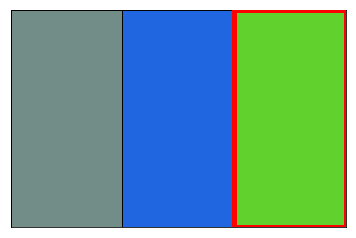

8615) Game: 7286-9 Round: 35
purple/blue


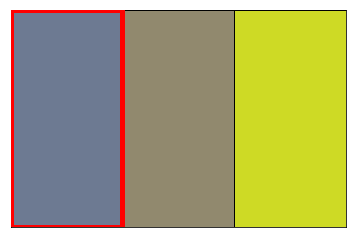

8616) Game: 7286-9 Round: 36
green


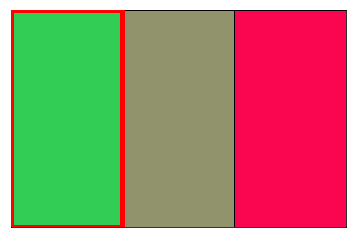

8617) Game: 7286-9 Round: 37
bright green


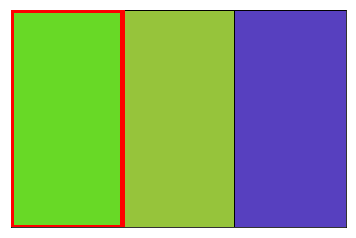

8618) Game: 7286-9 Round: 38
green


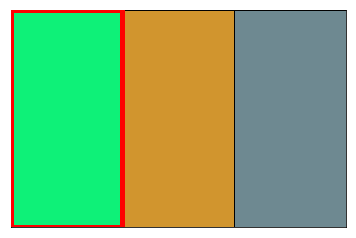

8619) Game: 7286-9 Round: 39
purple


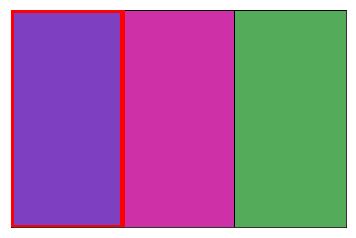

8620) Game: 7286-9 Round: 40
maroon


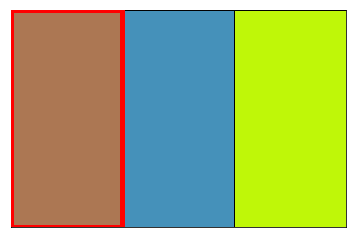

8621) Game: 7286-9 Round: 41
redish/moon


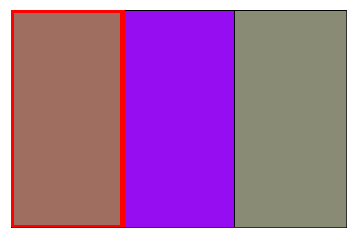

8622) Game: 7286-9 Round: 42
blue


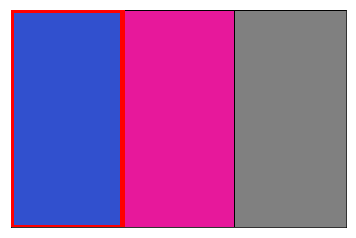

8623) Game: 7286-9 Round: 43
bright green


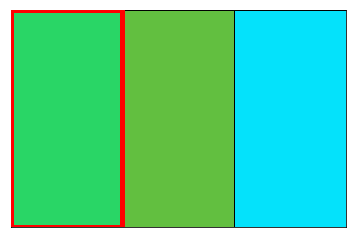

8624) Game: 7286-9 Round: 44
bright green


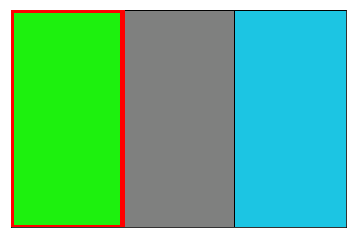

8625) Game: 7286-9 Round: 45
that one


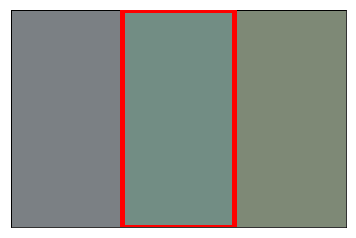

8626) Game: 7286-9 Round: 46
pink


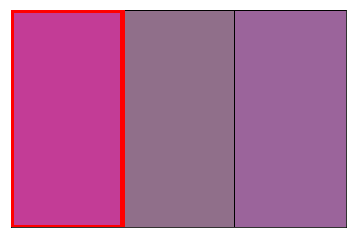

8627) Game: 7286-9 Round: 47
blue


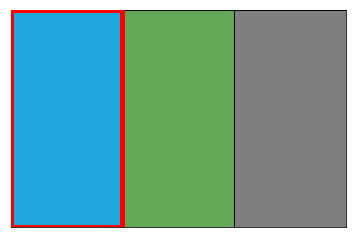

8628) Game: 7286-9 Round: 48
purple


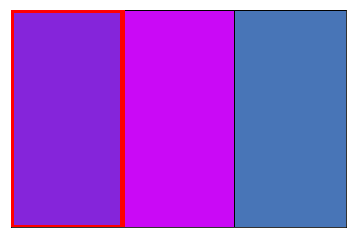

8629) Game: 7286-9 Round: 49
pink


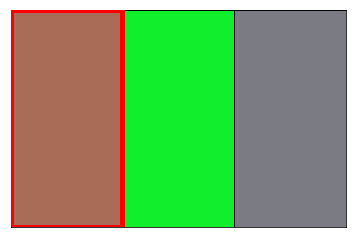

8630) Game: 7286-9 Round: 50
ugly green


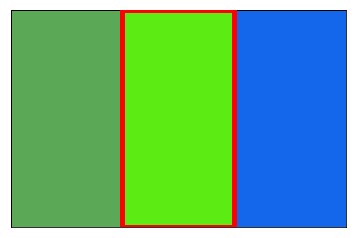

In [485]:
    dev_data.display_game_for_gameid('7286-9')

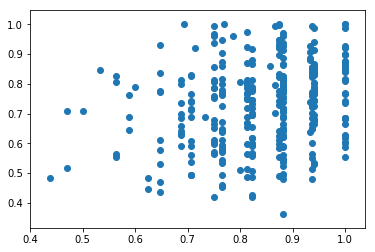

In [478]:
plt.scatter(suc_col_score_close.true_score, suc_col_score_close.model_score)

(array([ 3., 13., 25., 38., 37., 48., 61., 43., 25., 24.]),
 array([0.36337596, 0.42703819, 0.49070042, 0.55436265, 0.61802488,
        0.68168711, 0.74534934, 0.80901157, 0.8726738 , 0.93633603,
        0.99999825]),
 <a list of 10 Patch objects>)

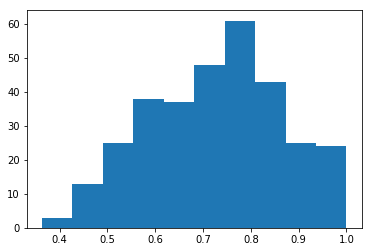

In [479]:
plt.hist(suc_col_score_close.model_score, 10)

(array([ 2.,  9., 11., 16., 36., 55., 54., 67., 44., 23.]),
 array([0.49090652, 0.54181587, 0.59272522, 0.64363456, 0.69454391,
        0.74545326, 0.79636261, 0.84727196, 0.8981813 , 0.94909065,
        1.        ]),
 <a list of 10 Patch objects>)

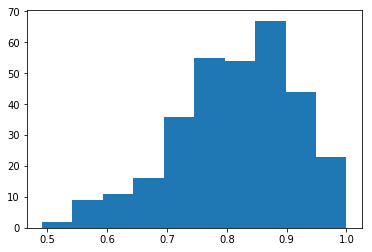

In [480]:
plt.hist(suc_col_score_df.groupby(["condition", "gameid"]).mean().xs('split', level='condition')['model_score'], 10)

(array([ 1.,  0.,  3.,  5., 11., 15., 56., 78., 95., 53.]),
 array([0.54632198, 0.59168978, 0.63705758, 0.68242539, 0.72779319,
        0.77316099, 0.81852879, 0.86389659, 0.9092644 , 0.9546322 ,
        1.        ]),
 <a list of 10 Patch objects>)

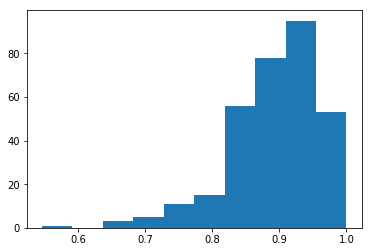

In [481]:
plt.hist(suc_col_score_df.groupby(["condition", "gameid"]).mean().xs('far', level='condition')['model_score'], 10)

In [441]:
stats.spearmanr(suc_col_scores_series.index, suc_col_scores_series.values)

SpearmanrResult(correlation=0.6470588235294118, pvalue=0.006742077007179868)

In [388]:
train_data.data.head().T

,0,1,2,3,4
gameid,1124-1,1124-1,1124-1,1124-1,1124-1
clkTime,1.45988e+12,1.45988e+12,1.45988e+12,1.45988e+12,1.45988e+12
roundNum,1,2,3,4,5
condition,close,far,close,split,far
clickStatus,distr2,target,distr2,distr1,target
clickColH,248,249,291,85,156
clickColS,92,25,59,21,84
clickColL,50,50,50,50,50
clickLocS,3,1,3,2,1
clickLocL,1,2,3,1,3


In [228]:
import random

In [229]:
# balance the dataset a bit more...
balanced_train = correct_train_sample + wrong_train
random.shuffle(balanced_train)

In [231]:
balanced_train[:10]

[yellow green,
 blue purple,
 purple,
 it's the brightest green,
 purp,
 darkest color,
 green,
 purple,
 purple,
 lighter purple?]

In [232]:
feature_handler = FeatureHandler(balanced_train, dev_data, caption_phi, color_phi, target_fn=success_target)

print("Obtaining training features") # get features even if you're runnning the pretrained model for example
train_features = feature_handler.train_features()
train_targets = feature_handler.train_targets()

print("Initializing model")
# model parameters
embed_dim = 100; hidden_dim = 100; # hard coded for example - 54 comes from color fourier phi



Obtaining training features
Initializing model


In [235]:
train = True
model_file_suc_bal = "../model/literal_listener_predict_success_balanced_5epoch_endings_tkn.params"

model_suc_bal = LiteralListenerPredictSuccess(PredictSuccess, num_epochs=5, criterion=nn.BCEWithLogitsLoss)
model_suc_bal.init_model(embed_dim = embed_dim, hidden_dim = hidden_dim, vocab_size = feature_handler.caption_featurizer.caption_indexer.size)



In [236]:
if train:
    print("Training model and saving to {}:".format(model_file_suc_bal))
    model_suc_bal.fit(train_features, train_targets)
    model_suc_bal.save_model(model_file_suc_bal)
else:
    print("Loading pretrained model")
    model_suc_bal.load_model(model_file_suc_bal)

Training model and saving to ../model/literal_listener_predict_success_balanced_5epoch_endings_tkn.params:
---EPOCH 0---
0m 0s (0:0 0.00%) 0.0007
0m 6s (0:1000 28.06%) 0.6905
0m 13s (0:2000 56.12%) 0.6586
0m 20s (0:3000 84.18%) 0.6616
---EPOCH 1---
0m 24s (1:0 0.00%) 0.0003
0m 32s (1:1000 28.06%) 0.6350
0m 40s (1:2000 56.12%) 0.6230
0m 47s (1:3000 84.18%) 0.6324
---EPOCH 2---
0m 52s (2:0 0.00%) 0.0002
0m 59s (2:1000 28.06%) 0.6045
1m 6s (2:2000 56.12%) 0.5986
1m 14s (2:3000 84.18%) 0.6037
---EPOCH 3---
1m 18s (3:0 0.00%) 0.0001
1m 25s (3:1000 28.06%) 0.5839
1m 32s (3:2000 56.12%) 0.5765
1m 39s (3:3000 84.18%) 0.5763
---EPOCH 4---
1m 43s (4:0 0.00%) 0.0001
1m 50s (4:1000 28.06%) 0.5642
1m 57s (4:2000 56.12%) 0.5545
2m 4s (4:3000 84.18%) 0.5523


In [238]:
x = evaluate_model(dev_data, feature_handler, model_suc_bal, output_to_score_suc, score_model, accuracy=False)

(0.12446953423484067, 0.026692406534640903)


In [304]:
# now let's try with oversampling:
correct_train_all = list(filter(lambda de: de.target_idx == de.click_idx, train_data.entries))

In [317]:
wrong_train_oversampled = list(np.resize(wrong_train, len(correct_train_all)))

In [313]:
len(wrong_train_oversampled) == len(correct_train_all)

True

In [318]:
wrong_train_oversampled

[The darker blue one,
 Medium pink ~ the medium dark one,
 lime,
 Neon pink,
 green,
 Hahaha. Me too. This one is purple. Not neon and not lavender,
 lightest shade of teal/blue/green,
 the darker gray,
 blue gray,
 the darker gray,
 olive green, darkest,
 purple on the right,
 darkest color,
 just pick a random one,
 darker olive,
 light blue,
 neon green,
 dark puprle,
 dark grey,
 DARK YOU IDIOT. This one is orange,
 dark purple,
 lime green,
 ugly tan,
 dark purple,
 dark purple,
 grey,
 medium green,
 orange,
 meduim green,
 teal,
 brownish yellow,
 Navy Blue,
 Darker Purple,
 Darker Purple,
 Grayish Purple ~ Doh,
 Not Green or Blue,
 normal blue,
 tan,
 purple,
 forest green,
 darker green,
 purple,
 gray,
 brighter red,
 darker blue,
 darker green,
 green,
 blue/green,
 purple,
 purple,
 dark green,
 green,
 brown,
 pale purple,
 dark greyish violet,
 pale pink,
 brown,
 gray,
 darkest blue,
 bright pink,
 darker gray,
 Hi ~ Target is green-blue square,
 Target is darkest purple

In [319]:
oversampled_train = correct_train_all + wrong_train_oversampled
random.shuffle(oversampled_train)

In [634]:
feature_handler_os = FeatureHandler(oversampled_train, dev_data_synth, caption_phi, color_phi, target_fn=success_target,
                                   randomized_colors=False)

In [635]:
train_features_os = feature_handler_os.train_features()
train_targets_os = feature_handler_os.train_targets()

In [324]:
train = True
model_file_suc_os = "../model/literal_listener_predict_success_oversampled_5epoch_endings_tkn.params"

model_suc_os = LiteralListenerPredictSuccess(PredictSuccess, num_epochs=5, criterion=nn.BCEWithLogitsLoss)
model_suc_os.init_model(embed_dim = embed_dim, hidden_dim = hidden_dim, vocab_size = feature_handler_os.caption_featurizer.caption_indexer.size)


In [325]:
if train:
    print("Training model and saving to {}:".format(model_file_suc_os))
    model_suc_os.fit(train_features_os, train_targets_os)
    model_suc_os.save_model(model_file_suc_os)
else:
    print("Loading pretrained model")
    model_suc_os.load_model(model_file_suc_os)

Training model and saving to ../model/literal_listener_predict_success_oversampled_5epoch_endings_tkn.params:
---EPOCH 0---
0m 0s (0:0 0.00%) 0.0006
0m 6s (0:1000 3.60%) 0.6904
0m 12s (0:2000 7.20%) 0.6708
0m 19s (0:3000 10.80%) 0.6639
0m 26s (0:4000 14.41%) 0.6598
0m 33s (0:5000 18.01%) 0.6519
0m 40s (0:6000 21.61%) 0.6599
0m 47s (0:7000 25.21%) 0.6453
0m 54s (0:8000 28.81%) 0.6347
1m 1s (0:9000 32.41%) 0.6619
1m 8s (0:10000 36.02%) 0.6334
1m 15s (0:11000 39.62%) 0.6284
1m 22s (0:12000 43.22%) 0.6377
1m 30s (0:13000 46.82%) 0.6183
1m 37s (0:14000 50.42%) 0.6462
1m 44s (0:15000 54.02%) 0.6396
1m 51s (0:16000 57.62%) 0.6321
1m 59s (0:17000 61.23%) 0.6321
2m 6s (0:18000 64.83%) 0.6108
2m 13s (0:19000 68.43%) 0.6346
2m 20s (0:20000 72.03%) 0.6172
2m 27s (0:21000 75.63%) 0.6365
2m 34s (0:22000 79.23%) 0.6276
2m 41s (0:23000 82.84%) 0.6089
2m 48s (0:24000 86.44%) 0.6251
2m 56s (0:25000 90.04%) 0.6157
3m 3s (0:26000 93.64%) 0.6250
3m 10s (0:27000 97.24%) 0.6286
---EPOCH 1---
3m 16s (1:0 0.00

In [352]:
if train:
    print("Training model and saving to {}:".format(model_file_suc_os))
    model_suc_os.fit(train_features, train_targets)
    model_suc_os.save_model(model_file_suc_os)
else:
    print("Loading pretrained model")
    model_suc_os.load_model(model_file_suc_os)

Training model and saving to ../model/literal_listener_predict_success_oversampled_5epoch_endings_tkn.params:
---EPOCH 0---
0m 0s (0:0 0.00%) 0.0011
0m 6s (0:1000 3.60%) 0.4161
0m 12s (0:2000 7.20%) 0.3905
0m 18s (0:3000 10.80%) 0.4295
0m 26s (0:4000 14.41%) 0.4445
0m 33s (0:5000 18.01%) 0.4313
0m 40s (0:6000 21.61%) 0.4461
0m 47s (0:7000 25.21%) 0.4095
0m 54s (0:8000 28.81%) 0.4124
1m 1s (0:9000 32.41%) 0.4287
1m 8s (0:10000 36.02%) 0.4262
1m 16s (0:11000 39.62%) 0.4282
1m 23s (0:12000 43.22%) 0.4145
1m 30s (0:13000 46.82%) 0.4146
1m 37s (0:14000 50.42%) 0.4454
1m 45s (0:15000 54.02%) 0.4174
1m 52s (0:16000 57.62%) 0.3904
1m 59s (0:17000 61.23%) 0.4226
2m 7s (0:18000 64.83%) 0.3961
2m 15s (0:19000 68.43%) 0.4224
2m 22s (0:20000 72.03%) 0.3976
2m 30s (0:21000 75.63%) 0.3923
2m 37s (0:22000 79.23%) 0.4159
2m 45s (0:23000 82.84%) 0.3769
2m 53s (0:24000 86.44%) 0.4569
3m 1s (0:25000 90.04%) 0.3783
3m 8s (0:26000 93.64%) 0.3903
3m 16s (0:27000 97.24%) 0.4456
---EPOCH 1---
3m 21s (1:0 0.00%

In [651]:
train = True
model_file_suc_os = "../model/literal_listener_predict_success_color3_oversampled_5epoch_endings_tkn.params"

model_suc_os = LiteralListenerPredictSuccess(PredictSuccessColor3, num_epochs=5, criterion=nn.BCEWithLogitsLoss, 
                                             use_color=True, optimizer=torch.optim.Adam, lr=0.008)
model_suc_os.init_model(embed_dim = embed_dim, hidden_dim = hidden_dim, 
                        vocab_size = feature_handler_os.caption_featurizer.caption_indexer.size,
                        color_in_dim=54, color_hidden_dim=100)



In [652]:
if train:
    print("Training model and saving to {}:".format(model_file_suc_os))
    model_suc_os.fit(train_features_os, train_targets_os)
    model_suc_os.save_model(model_file_suc_os)
else:
    print("Loading pretrained model")
    model_suc_os.load_model(model_file_suc_os)

Training model and saving to ../model/literal_listener_predict_success_color3_oversampled_5epoch_endings_tkn.params:
---EPOCH 0---
0m 0s (0:0 0.00%) 0.0007
0m 8s (0:1000 3.60%) 0.7204
0m 18s (0:2000 7.20%) 0.6772
0m 28s (0:3000 10.80%) 0.6817
0m 38s (0:4000 14.41%) 0.6781
0m 49s (0:5000 18.01%) 0.6775
1m 0s (0:6000 21.61%) 0.6855
1m 12s (0:7000 25.21%) 0.6638
1m 23s (0:8000 28.81%) 0.6602
1m 36s (0:9000 32.41%) 0.6696
1m 48s (0:10000 36.02%) 0.6736
2m 1s (0:11000 39.62%) 0.6425
2m 15s (0:12000 43.22%) 0.6442
2m 27s (0:13000 46.82%) 0.6626
2m 41s (0:14000 50.42%) 0.6456
2m 54s (0:15000 54.02%) 0.6477
3m 8s (0:16000 57.62%) 0.6563
3m 22s (0:17000 61.23%) 0.6605
3m 36s (0:18000 64.83%) 0.6332
3m 52s (0:19000 68.43%) 0.6542
4m 7s (0:20000 72.03%) 0.6480
4m 22s (0:21000 75.63%) 0.6375
4m 36s (0:22000 79.23%) 0.6243
4m 50s (0:23000 82.84%) 0.6336
5m 5s (0:24000 86.44%) 0.6439
5m 19s (0:25000 90.04%) 0.6419
5m 33s (0:26000 93.64%) 0.6291
5m 48s (0:27000 97.24%) 0.6145
---EPOCH 1---
5m 59s (1:

In [326]:
x = evaluate_model(dev_data, feature_handler, model_suc_os, output_to_score_suc, score_model, accuracy=False)

(0.3121385593346627, 1.3627509346030396e-08)


In [353]:
x = evaluate_model(dev_data, feature_handler, model_suc_os, output_to_score_suc, score_model, accuracy=False)

(0.2857047563786835, 2.2791370390166852e-07)


In [354]:
assess_targets_tgt_suc_os, model_outputs_suc_os, model_scores_suc_os, true_scores_grouped_suc_os, model_scores_grouped_suc_os = x

In [343]:
model_scores_bin_suc_os = [1 if s > 0. else 0 for s in model_scores_suc_os]


In [355]:
metrics.roc_auc_score(assess_targets_tgt_suc_os, model_scores_suc_os)

0.5133896542059472

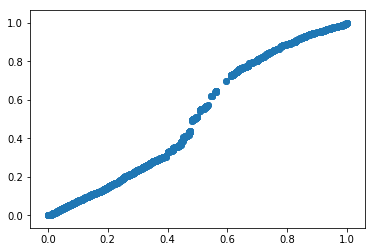

In [357]:
fpr, tpr, _ = metrics.roc_curve(assess_targets_tgt_suc_os, model_scores_suc_os, pos_label=1)
plt.scatter(fpr, tpr) # fpr and tpr from metrics.roc_score

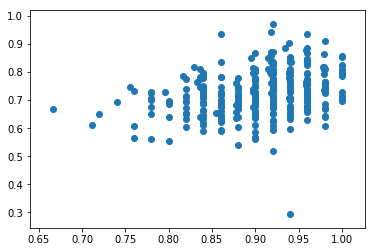

In [351]:
plt.scatter(true_scores_grouped_suc_os, model_scores_grouped_suc_os)
plt.show()

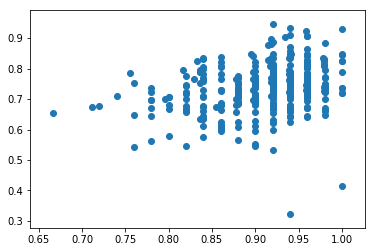

In [402]:
plt.scatter(true_scores_grouped_suc_os, model_scores_grouped_suc_os)
plt.show()

In [397]:
# from https://stackoverflow.com/questions/8118982/rounding-numbers-to-a-specific-resolution
def round_partial(value, res):
    return round(value/res) * res

In [405]:
true_scores_grouped_rounded_suc_os = [int(50*round_partial(score, 1/50)) for score in true_scores_grouped_suc_os]

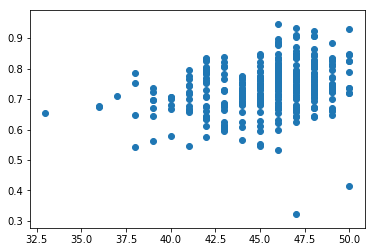

In [406]:
plt.scatter(true_scores_grouped_rounded_suc_os, model_scores_grouped_suc_os)
plt.show()

In [653]:
x = evaluate_model(dev_data_synth, feature_handler_os, model_suc_os, output_to_score_suc, score_model, accuracy=False)
assess_targets_tgt_suc_os_synth, model_outputs_suc_os_synth, model_scores_suc_os_synth, true_scores_grouped_suc_os_synth, model_scores_grouped_suc_os_synth = x


(0.023715765720001253, 0.5909307462088358)


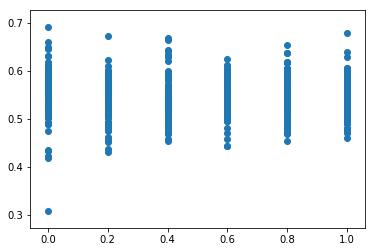

In [655]:
plt.scatter(true_scores_grouped_suc_os_synth, model_scores_grouped_suc_os_synth)
plt.show()

In [408]:
import pandas as pd

In [413]:
data = {'model_scores': model_scores_grouped_suc_os, 'true_scores': true_scores_grouped_rounded_suc_os}
suc_os_df = pd.DataFrame(data)
suc_os_scores_series = suc_os_df.groupby('true_scores').mean()['model_scores']
plt.scatter(suc_os_scores_series.index, suc_os_scores_series.values)

In [418]:
suc_os_df.groupby('true_scores').mean()

,model_scores
true_scores,
33,0.653433
36,0.674656
37,0.711406
38,0.681863
39,0.676143
40,0.672864
41,0.706229
42,0.727521
43,0.697183


In [419]:
suc_os_scores_series = suc_os_df.groupby('true_scores').mean()['model_scores']

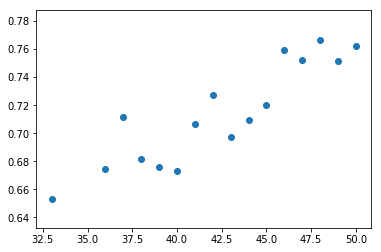

In [422]:
plt.scatter(suc_os_scores_series.index, suc_os_scores_series.values)

In [423]:
stats.pearsonr(suc_os_scores_series.index, suc_os_scores_series.values)

(0.8988771370565319, 2.2110388855592683e-06)

In [347]:
metrics.auc(fpr, tpr)

0.5431088746418867

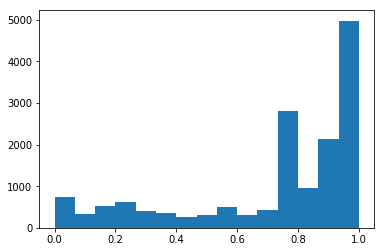

In [334]:
plt.hist(model_scores_suc_os, 15)
plt.show()

In [391]:
# now let's try training the model that includes colors AND captions with oversampling:
train = True
model_file_suc_col_os = "../model/literal_listener_predict_success_colors_oversampled_5epoch_endings_tkn.params"

model_suc_col_os = LiteralListenerPredictSuccess(PredictSuccessColor, num_epochs=5, criterion=nn.BCEWithLogitsLoss)
model_suc_col_os.init_model(embed_dim = embed_dim, hidden_dim = hidden_dim, 
                     vocab_size = feature_handler.caption_featurizer.caption_indexer.size,
                     color_in_dim = 54, color_hidden_dim=100)



In [392]:
if train:
    print("Training model and saving to {}:".format(model_file_suc_col_os))
    model_suc_col_os.fit(train_features, train_targets)
    model_suc_col_os.save_model(model_file_suc_col_os)
else:
    print("Loading pretrained model")
    model_suc_col_os.load_model(model_file_suc_col_os)

Training model and saving to ../model/literal_listener_predict_success_colors_oversampled_5epoch_endings_tkn.params:
---EPOCH 0---
0m 0s (0:0 0.00%) 0.0007
0m 7s (0:1000 3.60%) 0.6877
0m 16s (0:2000 7.20%) 0.6640
0m 24s (0:3000 10.80%) 0.6628
0m 32s (0:4000 14.41%) 0.6602
0m 40s (0:5000 18.01%) 0.6426
0m 49s (0:6000 21.61%) 0.6579
0m 57s (0:7000 25.21%) 0.6342
1m 6s (0:8000 28.81%) 0.6328
1m 14s (0:9000 32.41%) 0.6460
1m 23s (0:10000 36.02%) 0.6166
1m 31s (0:11000 39.62%) 0.6303
1m 40s (0:12000 43.22%) 0.6246
1m 49s (0:13000 46.82%) 0.6211
1m 57s (0:14000 50.42%) 0.6263
2m 8s (0:15000 54.02%) 0.6267
2m 17s (0:16000 57.62%) 0.6088
2m 26s (0:17000 61.23%) 0.6182
2m 35s (0:18000 64.83%) 0.5879
2m 44s (0:19000 68.43%) 0.6239
2m 53s (0:20000 72.03%) 0.5920
3m 3s (0:21000 75.63%) 0.6100
3m 11s (0:22000 79.23%) 0.5989
3m 20s (0:23000 82.84%) 0.5816
3m 29s (0:24000 86.44%) 0.5964
3m 38s (0:25000 90.04%) 0.5909
3m 47s (0:26000 93.64%) 0.5952
3m 56s (0:27000 97.24%) 0.5899
---EPOCH 1---
4m 2s (1

In [394]:
x = evaluate_model(dev_data, feature_handler, model_suc_col_os, output_to_score_suc, score_model, accuracy=False)

(0.2857986460260847, 2.2575665866691015e-07)


In [395]:
assess_targets_tgt_suc_col_os, model_outputs_suc_col_os, model_scores_suc_col_os, true_scores_grouped_suc_col_os, model_scores_grouped_suc_col_os = x

In [396]:
metrics.roc_auc_score(assess_targets_tgt_suc_col_os, model_scores_suc_col_os)

0.5836952481022781

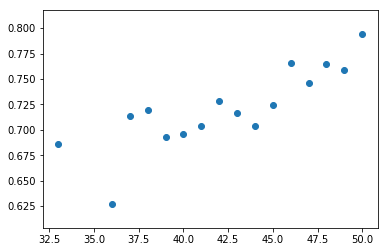

(0.8287567585688326, 7.267762866873444e-05)

In [426]:
true_scores_grouped_rounded_suc_col_os = [int(50*round_partial(score, 1/50)) for score in true_scores_grouped_suc_col_os]
suc_col_os_df = pd.DataFrame({'model_scores': model_scores_grouped_suc_col_os, 'true_scores': true_scores_grouped_rounded_suc_col_os})
suc_col_os_scores_series = suc_col_os_df.groupby('true_scores').mean()['model_scores']
plt.scatter(suc_col_os_scores_series.index, suc_col_os_scores_series.values)
plt.show()
stats.pearsonr(suc_col_os_scores_series.index, suc_col_os_scores_series.values)

In [ ]:
stats.pearsonr(suc_col_os_scores_series.index, suc_col_os_scores_series.values)

In [242]:
# logistic regression classifier for colors
feature_handler = FeatureHandler(train_data, dev_data, caption_phi, color_phi, target_fn=success_target)



In [244]:
train_features = feature_handler.train_features()
train_targets = feature_handler.train_targets()

In [246]:
train_features[0]

[array([0, 1, 2, 3, 4, 5, 6]),
 array([[ 1.0000000e+00, -9.7831738e-01,  9.1420978e-01,  9.7831738e-01,
         -1.0000000e+00,  9.7831738e-01,  9.1420978e-01, -9.7831738e-01,
          1.0000000e+00, -5.5557024e-01,  3.7131721e-01, -1.7096189e-01,
         -7.1573085e-01,  5.5557024e-01, -3.7131721e-01, -8.4485358e-01,
          7.1573085e-01, -5.5557024e-01, -3.8268343e-01,  5.6573182e-01,
         -7.2424710e-01, -1.8303989e-01,  3.8268343e-01, -5.6573182e-01,
          2.4541229e-02,  1.8303989e-01, -3.8268343e-01,  0.0000000e+00,
         -2.0711137e-01,  4.0524131e-01, -2.0711137e-01, -1.2246469e-16,
          2.0711137e-01, -4.0524131e-01,  2.0711137e-01,  0.0000000e+00,
         -8.3146960e-01,  9.2850608e-01, -9.8527765e-01, -6.9837624e-01,
          8.3146960e-01, -9.2850608e-01, -5.3499764e-01,  6.9837624e-01,
         -8.3146960e-01,  9.2387950e-01, -8.2458931e-01,  6.8954057e-01,
          9.8310548e-01, -9.2387950e-01,  8.2458931e-01,  9.9969882e-01,
         -9.8310548e

In [247]:
model_logreg = LogisticRegression(fit_intercept=True, solver='liblinear')

In [252]:
train_features_color = np.array([f[1].flatten() for f in train_features])

In [253]:
train_features_color[0]

array([ 1.0000000e+00, -9.7831738e-01,  9.1420978e-01,  9.7831738e-01,
       -1.0000000e+00,  9.7831738e-01,  9.1420978e-01, -9.7831738e-01,
        1.0000000e+00, -5.5557024e-01,  3.7131721e-01, -1.7096189e-01,
       -7.1573085e-01,  5.5557024e-01, -3.7131721e-01, -8.4485358e-01,
        7.1573085e-01, -5.5557024e-01, -3.8268343e-01,  5.6573182e-01,
       -7.2424710e-01, -1.8303989e-01,  3.8268343e-01, -5.6573182e-01,
        2.4541229e-02,  1.8303989e-01, -3.8268343e-01,  0.0000000e+00,
       -2.0711137e-01,  4.0524131e-01, -2.0711137e-01, -1.2246469e-16,
        2.0711137e-01, -4.0524131e-01,  2.0711137e-01,  0.0000000e+00,
       -8.3146960e-01,  9.2850608e-01, -9.8527765e-01, -6.9837624e-01,
        8.3146960e-01, -9.2850608e-01, -5.3499764e-01,  6.9837624e-01,
       -8.3146960e-01,  9.2387950e-01, -8.2458931e-01,  6.8954057e-01,
        9.8310548e-01, -9.2387950e-01,  8.2458931e-01,  9.9969882e-01,
       -9.8310548e-01,  9.2387950e-01,  1.0000000e+00, -9.5694035e-01,
      

In [275]:
clf = model_logreg.fit(train_features_color, train_targets)

In [290]:
dev_features = feature_handler.test_features()
dev_targets = feature_handler.test_targets()

In [291]:
dev_features_color = np.array([f[1].flatten() for f in dev_features])

In [292]:
predictions = clf.predict(dev_features_color)

In [293]:
metrics.f1_score(predictions, dev_targets, average="macro")

/Users/benjaminnewman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.4747779453661806

In [295]:
len(dev_targets)

15670

In [296]:
len(predictions)

15670

In [297]:
score_model(dev_data, predictions)

/Users/benjaminnewman/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


((nan, 1.0), gameid
 0022-7    0.938776
 0069-8    0.960000
 0070-1    0.780000
 0106-1    0.880000
 0109-c    0.960000
 0137-f    0.920000
 0197-6    0.920000
 0217-e    1.000000
 0219-7    0.860000
 0239-7    0.980000
 0255-b    0.920000
 0265-e    0.840000
 0283-7    0.900000
 0315-b    0.840000
 0322-8    0.940000
 0375-6    0.980000
 0389-5    0.897959
 0392-6    0.920000
 0398-f    0.820000
 0415-a    0.860000
 0433-7    1.000000
 0479-6    0.860000
 0519-9    0.880000
 0529-2    0.940000
 0580-7    0.920000
 0699-d    0.920000
 0713-f    0.960000
 0716-6    0.940000
 0736-7    0.940000
 0762-d    0.980000
             ...   
 8767-6    0.900000
 8792-7    0.880000
 8794-6    0.940000
 8814-1    0.840000
 8891-9    0.920000
 8958-0    0.860000
 8970-0    0.900000
 8972-7    0.860000
 8978-9    0.920000
 9038-b    0.880000
 9086-a    0.900000
 9260-e    0.880000
 9272-8    0.840000
 9288-a    0.900000
 9307-f    0.958333
 9444-5    0.900000
 9487-1    0.980000
 9601-f    0.940000


In [264]:
feature_handler_balanced = FeatureHandler(balanced_train, dev_data, caption_phi, color_phi, target_fn=success_target)
train_features_bal = feature_handler_balanced.train_features()
train_targets_bal = feature_handler_balanced.train_targets()




In [265]:
train_features_color_bal = np.array([f[1].flatten() for f in train_features_bal])

In [300]:
clf_bal = model_logreg.fit(train_features_color_bal, train_targets_bal)

In [301]:
predictions_bal = clf_bal.predict(dev_features_color)

In [302]:
metrics.f1_score(predictions_bal, dev_targets, average="macro")

0.41243824275666946

In [282]:
output_to_score_lr = lambda model_output, targets: model_output
output_to_score_dummy = lambda model_output, targets: targets

In [303]:
score_model(dev_data, predictions_bal)

((-0.011888237578845872, 0.8330157549367396), gameid
 0022-7    0.938776
 0069-8    0.960000
 0070-1    0.780000
 0106-1    0.880000
 0109-c    0.960000
 0137-f    0.920000
 0197-6    0.920000
 0217-e    1.000000
 0219-7    0.860000
 0239-7    0.980000
 0255-b    0.920000
 0265-e    0.840000
 0283-7    0.900000
 0315-b    0.840000
 0322-8    0.940000
 0375-6    0.980000
 0389-5    0.897959
 0392-6    0.920000
 0398-f    0.820000
 0415-a    0.860000
 0433-7    1.000000
 0479-6    0.860000
 0519-9    0.880000
 0529-2    0.940000
 0580-7    0.920000
 0699-d    0.920000
 0713-f    0.960000
 0716-6    0.940000
 0736-7    0.940000
 0762-d    0.980000
             ...   
 8767-6    0.900000
 8792-7    0.880000
 8794-6    0.940000
 8814-1    0.840000
 8891-9    0.920000
 8958-0    0.860000
 8970-0    0.900000
 8972-7    0.860000
 8978-9    0.920000
 9038-b    0.880000
 9086-a    0.900000
 9260-e    0.880000
 9272-8    0.840000
 9288-a    0.900000
 9307-f    0.958333
 9444-5    0.900000
 9487-1

In [ ]:
# e

In [ ]:
def bow_phi(caption_indices):
    features = Counter()
    for word_idx in caption_indices:
        features[word_idx] += 1
    return features
        